# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    celeb_data = datasets.ImageFolder(data_dir, transform) 
    data_loader = torch.utils.data.DataLoader(celeb_data, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

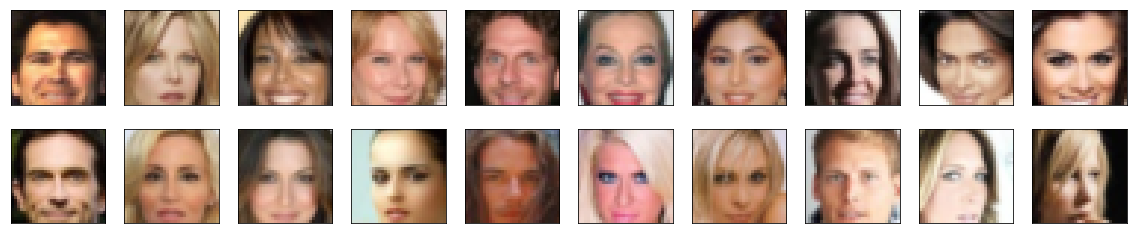

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min_r, max_r = feature_range
    x = x*(max_r - min_r)  + min_r
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # Input of 32x32
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)  # Too much? Good or bad?
        # 2x2
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out) # For some reason we end with a 50x1x1x1 tensor...
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        # The first transpose conv layer should have a 4x4 size and depth of 512 = (4*32)
        self.fc = nn.Linear(z_size, conv_dim*4*4*4) 
        # The output of fc will be reshaped into a 4*4*512 vector
        self.tconv1 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, stride=2, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(conv_dim*2)
        self.tconv2 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(conv_dim)
        self.tconv3 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1, bias=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        # reshaping the vector to (batchsize, conv depth, 4size, 4size)
        out = out.view(-1, self.conv_dim*4, 4, 4) 
        
        out = F.relu(self.norm1(self.tconv1(out)))
        out = F.relu(self.norm2(self.tconv2(out)))
        out = self.tconv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

E:\dev\venv\deeplearnudacity\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (tconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    # Adding smoothing
    labels = torch.ones(D_out.size(0)) * 0.9
    
    if train_on_gpu:
        labels = labels.cuda()
    
    # loss = torch.mean((D_out-)**2)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    #loss = torch.mean(D_out**2)
    labels = torch.zeros(D_out.size(0))
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            # 1.1 Real images train
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            
            d_real_loss = real_loss(D_real)
            
            # 1.2 Fake images
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            
            D_fake = D(fake_images)
            
            # compute the fake loss
            d_fake_loss = fake_loss(D_fake)
            
            # final discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # 2.1 Train with
            # Generate fake img
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            D_fake = D(fake_images)
            
            # compute generator loss on fake img
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
                
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
            


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4349 | g_loss: 0.7697
Epoch [    1/   50] | d_loss: 0.4703 | g_loss: 3.0456
Epoch [    1/   50] | d_loss: 0.3944 | g_loss: 3.5072
Epoch [    1/   50] | d_loss: 0.4988 | g_loss: 2.4481
Epoch [    1/   50] | d_loss: 0.6086 | g_loss: 3.5930
Epoch [    1/   50] | d_loss: 0.6585 | g_loss: 5.0935
Epoch [    1/   50] | d_loss: 0.7563 | g_loss: 2.2048
Epoch [    1/   50] | d_loss: 0.4969 | g_loss: 2.5144
Epoch [    1/   50] | d_loss: 1.0513 | g_loss: 3.3929
Epoch [    1/   50] | d_loss: 0.6094 | g_loss: 3.0047
Epoch [    1/   50] | d_loss: 1.2389 | g_loss: 2.7103
Epoch [    1/   50] | d_loss: 0.5130 | g_loss: 2.9643
Epoch [    1/   50] | d_loss: 0.6166 | g_loss: 1.8986
Epoch [    1/   50] | d_loss: 0.4099 | g_loss: 3.0473
Epoch [    1/   50] | d_loss: 0.4704 | g_loss: 3.0628
Epoch [    1/   50] | d_loss: 0.5951 | g_loss: 1.9624
Epoch [    1/   50] | d_loss: 0.6479 | g_loss: 1.9458
Epoch [    1/   50] | d_loss: 0.5909 | g_loss: 2.3332
Epoch [    1/   50] | d_loss

Epoch [    2/   50] | d_loss: 1.0685 | g_loss: 1.3006
Epoch [    2/   50] | d_loss: 1.1659 | g_loss: 1.2770
Epoch [    2/   50] | d_loss: 0.6652 | g_loss: 1.6856
Epoch [    2/   50] | d_loss: 0.7376 | g_loss: 2.0619
Epoch [    2/   50] | d_loss: 0.9274 | g_loss: 1.3413
Epoch [    2/   50] | d_loss: 1.0237 | g_loss: 1.5938
Epoch [    2/   50] | d_loss: 0.7704 | g_loss: 1.9526
Epoch [    2/   50] | d_loss: 1.4795 | g_loss: 1.2318
Epoch [    2/   50] | d_loss: 0.7137 | g_loss: 2.1717
Epoch [    2/   50] | d_loss: 0.9470 | g_loss: 1.2322
Epoch [    2/   50] | d_loss: 1.4885 | g_loss: 2.4392
Epoch [    2/   50] | d_loss: 0.7464 | g_loss: 3.1195
Epoch [    2/   50] | d_loss: 0.5523 | g_loss: 2.4793
Epoch [    2/   50] | d_loss: 0.7214 | g_loss: 1.0102
Epoch [    2/   50] | d_loss: 0.8297 | g_loss: 1.3049
Epoch [    2/   50] | d_loss: 0.6832 | g_loss: 1.0226
Epoch [    2/   50] | d_loss: 1.0075 | g_loss: 1.0839
Epoch [    2/   50] | d_loss: 0.5383 | g_loss: 1.7102
Epoch [    2/   50] | d_loss

Epoch [    4/   50] | d_loss: 0.9047 | g_loss: 1.1016
Epoch [    4/   50] | d_loss: 1.3096 | g_loss: 1.2137
Epoch [    4/   50] | d_loss: 0.9655 | g_loss: 2.1264
Epoch [    4/   50] | d_loss: 0.6627 | g_loss: 2.7763
Epoch [    4/   50] | d_loss: 0.8078 | g_loss: 1.9542
Epoch [    4/   50] | d_loss: 0.7165 | g_loss: 0.7998
Epoch [    4/   50] | d_loss: 0.6527 | g_loss: 1.3112
Epoch [    4/   50] | d_loss: 0.5676 | g_loss: 1.7196
Epoch [    4/   50] | d_loss: 0.4876 | g_loss: 2.7132
Epoch [    4/   50] | d_loss: 0.5048 | g_loss: 3.1611
Epoch [    4/   50] | d_loss: 0.8579 | g_loss: 1.4940
Epoch [    4/   50] | d_loss: 0.7496 | g_loss: 2.8225
Epoch [    4/   50] | d_loss: 0.8985 | g_loss: 3.0228
Epoch [    4/   50] | d_loss: 1.5181 | g_loss: 3.6981
Epoch [    4/   50] | d_loss: 0.5864 | g_loss: 2.5348
Epoch [    4/   50] | d_loss: 0.5356 | g_loss: 1.6850
Epoch [    4/   50] | d_loss: 0.4665 | g_loss: 2.1217
Epoch [    4/   50] | d_loss: 0.8480 | g_loss: 1.6036
Epoch [    4/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.6566 | g_loss: 2.2297
Epoch [    6/   50] | d_loss: 0.5450 | g_loss: 2.7536
Epoch [    6/   50] | d_loss: 0.5739 | g_loss: 1.9954
Epoch [    6/   50] | d_loss: 0.5985 | g_loss: 0.6958
Epoch [    6/   50] | d_loss: 0.3895 | g_loss: 2.6297
Epoch [    6/   50] | d_loss: 0.4955 | g_loss: 2.0369
Epoch [    6/   50] | d_loss: 0.4578 | g_loss: 0.7471
Epoch [    6/   50] | d_loss: 0.5168 | g_loss: 2.2144
Epoch [    6/   50] | d_loss: 0.4278 | g_loss: 2.1240
Epoch [    6/   50] | d_loss: 0.7027 | g_loss: 2.3064
Epoch [    6/   50] | d_loss: 0.4946 | g_loss: 2.4911
Epoch [    6/   50] | d_loss: 0.6426 | g_loss: 2.0297
Epoch [    6/   50] | d_loss: 0.7030 | g_loss: 2.2345
Epoch [    6/   50] | d_loss: 1.2418 | g_loss: 0.8636
Epoch [    6/   50] | d_loss: 0.7676 | g_loss: 1.7407
Epoch [    6/   50] | d_loss: 0.4115 | g_loss: 2.2531
Epoch [    6/   50] | d_loss: 0.6209 | g_loss: 2.6829
Epoch [    6/   50] | d_loss: 0.8521 | g_loss: 2.7564
Epoch [    6/   50] | d_loss

Epoch [    7/   50] | d_loss: 0.4388 | g_loss: 3.4029
Epoch [    7/   50] | d_loss: 0.7113 | g_loss: 2.7436
Epoch [    7/   50] | d_loss: 0.6378 | g_loss: 3.1514
Epoch [    7/   50] | d_loss: 0.4868 | g_loss: 2.3932
Epoch [    7/   50] | d_loss: 0.5492 | g_loss: 3.3828
Epoch [    7/   50] | d_loss: 0.4867 | g_loss: 3.4617
Epoch [    7/   50] | d_loss: 0.8616 | g_loss: 2.4019
Epoch [    7/   50] | d_loss: 0.4205 | g_loss: 4.0222
Epoch [    7/   50] | d_loss: 0.4301 | g_loss: 4.0926
Epoch [    7/   50] | d_loss: 0.4497 | g_loss: 3.2702
Epoch [    7/   50] | d_loss: 0.8783 | g_loss: 4.4615
Epoch [    7/   50] | d_loss: 0.5554 | g_loss: 3.4420
Epoch [    7/   50] | d_loss: 0.5110 | g_loss: 4.1552
Epoch [    7/   50] | d_loss: 0.4831 | g_loss: 2.8476
Epoch [    7/   50] | d_loss: 0.7119 | g_loss: 2.8300
Epoch [    7/   50] | d_loss: 0.5896 | g_loss: 1.8359
Epoch [    7/   50] | d_loss: 0.4929 | g_loss: 1.6126
Epoch [    7/   50] | d_loss: 0.5964 | g_loss: 1.9792
Epoch [    7/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.6362 | g_loss: 1.2908
Epoch [    9/   50] | d_loss: 0.4918 | g_loss: 1.5624
Epoch [    9/   50] | d_loss: 0.6004 | g_loss: 1.8251
Epoch [    9/   50] | d_loss: 0.3831 | g_loss: 4.5585
Epoch [    9/   50] | d_loss: 0.4059 | g_loss: 2.9140
Epoch [    9/   50] | d_loss: 0.8816 | g_loss: 3.0339
Epoch [    9/   50] | d_loss: 0.4186 | g_loss: 3.0963
Epoch [    9/   50] | d_loss: 0.3854 | g_loss: 3.9822
Epoch [    9/   50] | d_loss: 1.1810 | g_loss: 1.7462
Epoch [    9/   50] | d_loss: 0.4122 | g_loss: 5.1858
Epoch [    9/   50] | d_loss: 0.4464 | g_loss: 3.6701
Epoch [    9/   50] | d_loss: 0.4870 | g_loss: 3.1858
Epoch [    9/   50] | d_loss: 0.4391 | g_loss: 2.8032
Epoch [    9/   50] | d_loss: 0.8833 | g_loss: 3.0116
Epoch [    9/   50] | d_loss: 0.4458 | g_loss: 5.2002
Epoch [    9/   50] | d_loss: 0.5176 | g_loss: 2.7930
Epoch [    9/   50] | d_loss: 0.5962 | g_loss: 1.1833
Epoch [    9/   50] | d_loss: 1.2473 | g_loss: 2.0079
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.5026 | g_loss: 3.3632
Epoch [   11/   50] | d_loss: 0.3797 | g_loss: 3.4854
Epoch [   11/   50] | d_loss: 0.4620 | g_loss: 3.1836
Epoch [   11/   50] | d_loss: 0.4771 | g_loss: 4.4983
Epoch [   11/   50] | d_loss: 1.0331 | g_loss: 0.8956
Epoch [   11/   50] | d_loss: 0.4590 | g_loss: 4.7636
Epoch [   11/   50] | d_loss: 0.3603 | g_loss: 2.4102
Epoch [   11/   50] | d_loss: 0.3913 | g_loss: 3.9419
Epoch [   11/   50] | d_loss: 0.5317 | g_loss: 3.2059
Epoch [   11/   50] | d_loss: 0.3990 | g_loss: 2.1607
Epoch [   11/   50] | d_loss: 0.3817 | g_loss: 3.1060
Epoch [   11/   50] | d_loss: 0.9460 | g_loss: 3.2647
Epoch [   11/   50] | d_loss: 0.4529 | g_loss: 4.0703
Epoch [   11/   50] | d_loss: 0.4120 | g_loss: 3.4136
Epoch [   11/   50] | d_loss: 0.6174 | g_loss: 4.1501
Epoch [   11/   50] | d_loss: 0.4619 | g_loss: 3.4811
Epoch [   11/   50] | d_loss: 0.3991 | g_loss: 5.0525
Epoch [   11/   50] | d_loss: 0.5898 | g_loss: 2.9795
Epoch [   11/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.8936 | g_loss: 2.4699
Epoch [   12/   50] | d_loss: 0.4066 | g_loss: 2.0608
Epoch [   12/   50] | d_loss: 0.3817 | g_loss: 3.2124
Epoch [   12/   50] | d_loss: 0.7369 | g_loss: 1.9906
Epoch [   12/   50] | d_loss: 0.4487 | g_loss: 2.3580
Epoch [   12/   50] | d_loss: 0.4096 | g_loss: 5.2438
Epoch [   12/   50] | d_loss: 0.3944 | g_loss: 4.5473
Epoch [   12/   50] | d_loss: 0.6106 | g_loss: 4.2887
Epoch [   12/   50] | d_loss: 0.4101 | g_loss: 4.4513
Epoch [   12/   50] | d_loss: 0.3961 | g_loss: 3.4051
Epoch [   12/   50] | d_loss: 0.3958 | g_loss: 4.2960
Epoch [   12/   50] | d_loss: 0.3448 | g_loss: 5.4775
Epoch [   12/   50] | d_loss: 0.3759 | g_loss: 4.9599
Epoch [   12/   50] | d_loss: 0.4482 | g_loss: 4.0173
Epoch [   12/   50] | d_loss: 0.5835 | g_loss: 2.8633
Epoch [   12/   50] | d_loss: 0.3843 | g_loss: 2.2104
Epoch [   12/   50] | d_loss: 0.3960 | g_loss: 5.2371
Epoch [   12/   50] | d_loss: 0.3893 | g_loss: 4.3743
Epoch [   12/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.3454 | g_loss: 3.1807
Epoch [   14/   50] | d_loss: 0.4642 | g_loss: 3.3952
Epoch [   14/   50] | d_loss: 0.3692 | g_loss: 4.3359
Epoch [   14/   50] | d_loss: 0.5019 | g_loss: 4.5652
Epoch [   14/   50] | d_loss: 0.4467 | g_loss: 3.3579
Epoch [   14/   50] | d_loss: 0.3532 | g_loss: 5.2296
Epoch [   14/   50] | d_loss: 0.4306 | g_loss: 3.1284
Epoch [   14/   50] | d_loss: 0.4385 | g_loss: 3.9451
Epoch [   14/   50] | d_loss: 0.3875 | g_loss: 3.5673
Epoch [   14/   50] | d_loss: 0.3999 | g_loss: 4.1631
Epoch [   14/   50] | d_loss: 0.4484 | g_loss: 2.0778
Epoch [   14/   50] | d_loss: 0.3752 | g_loss: 2.6777
Epoch [   14/   50] | d_loss: 0.8289 | g_loss: 2.6120
Epoch [   14/   50] | d_loss: 0.4964 | g_loss: 3.2874
Epoch [   14/   50] | d_loss: 0.5621 | g_loss: 3.2684
Epoch [   14/   50] | d_loss: 0.7552 | g_loss: 4.2701
Epoch [   14/   50] | d_loss: 0.4235 | g_loss: 5.1011
Epoch [   14/   50] | d_loss: 0.3989 | g_loss: 1.9854
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.4472 | g_loss: 3.2585
Epoch [   16/   50] | d_loss: 0.5310 | g_loss: 3.2249
Epoch [   16/   50] | d_loss: 0.5274 | g_loss: 2.8554
Epoch [   16/   50] | d_loss: 0.3687 | g_loss: 3.4954
Epoch [   16/   50] | d_loss: 0.4205 | g_loss: 4.0638
Epoch [   16/   50] | d_loss: 0.4177 | g_loss: 4.4442
Epoch [   16/   50] | d_loss: 0.4753 | g_loss: 4.0921
Epoch [   16/   50] | d_loss: 0.3733 | g_loss: 2.5047
Epoch [   16/   50] | d_loss: 0.5917 | g_loss: 1.7109
Epoch [   16/   50] | d_loss: 0.3575 | g_loss: 4.8467
Epoch [   16/   50] | d_loss: 0.3658 | g_loss: 3.7048
Epoch [   16/   50] | d_loss: 0.6118 | g_loss: 1.8554
Epoch [   16/   50] | d_loss: 0.4022 | g_loss: 3.8623
Epoch [   16/   50] | d_loss: 0.4558 | g_loss: 4.2922
Epoch [   16/   50] | d_loss: 0.3778 | g_loss: 1.7292
Epoch [   16/   50] | d_loss: 0.4415 | g_loss: 4.1219
Epoch [   16/   50] | d_loss: 1.1196 | g_loss: 1.6422
Epoch [   16/   50] | d_loss: 0.3869 | g_loss: 3.7040
Epoch [   16/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.5717 | g_loss: 2.9238
Epoch [   17/   50] | d_loss: 0.5634 | g_loss: 3.2774
Epoch [   17/   50] | d_loss: 0.3850 | g_loss: 4.4200
Epoch [   17/   50] | d_loss: 0.3676 | g_loss: 3.8390
Epoch [   17/   50] | d_loss: 0.3710 | g_loss: 3.4756
Epoch [   17/   50] | d_loss: 0.4000 | g_loss: 2.8762
Epoch [   17/   50] | d_loss: 0.3919 | g_loss: 4.3264
Epoch [   17/   50] | d_loss: 0.4253 | g_loss: 3.7868
Epoch [   17/   50] | d_loss: 0.4147 | g_loss: 5.1332
Epoch [   17/   50] | d_loss: 0.3586 | g_loss: 4.7393
Epoch [   17/   50] | d_loss: 0.4118 | g_loss: 3.8278
Epoch [   17/   50] | d_loss: 0.4201 | g_loss: 4.6187
Epoch [   17/   50] | d_loss: 0.5860 | g_loss: 3.7548
Epoch [   17/   50] | d_loss: 0.3583 | g_loss: 2.8289
Epoch [   17/   50] | d_loss: 0.3656 | g_loss: 4.6739
Epoch [   17/   50] | d_loss: 0.3930 | g_loss: 5.8444
Epoch [   17/   50] | d_loss: 0.4118 | g_loss: 3.8147
Epoch [   17/   50] | d_loss: 0.6538 | g_loss: 2.8847
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.3765 | g_loss: 3.9198
Epoch [   19/   50] | d_loss: 0.3878 | g_loss: 3.2546
Epoch [   19/   50] | d_loss: 0.3610 | g_loss: 4.4131
Epoch [   19/   50] | d_loss: 0.4466 | g_loss: 1.9073
Epoch [   19/   50] | d_loss: 0.3836 | g_loss: 3.3592
Epoch [   19/   50] | d_loss: 0.3923 | g_loss: 4.5492
Epoch [   19/   50] | d_loss: 0.3880 | g_loss: 3.5394
Epoch [   19/   50] | d_loss: 0.3941 | g_loss: 4.0526
Epoch [   19/   50] | d_loss: 0.3673 | g_loss: 4.7223
Epoch [   19/   50] | d_loss: 0.4046 | g_loss: 4.5040
Epoch [   19/   50] | d_loss: 0.6884 | g_loss: 2.7087
Epoch [   19/   50] | d_loss: 0.4103 | g_loss: 3.9035
Epoch [   19/   50] | d_loss: 0.3827 | g_loss: 2.4355
Epoch [   19/   50] | d_loss: 0.3638 | g_loss: 4.6299
Epoch [   19/   50] | d_loss: 0.3781 | g_loss: 3.7169
Epoch [   19/   50] | d_loss: 0.4283 | g_loss: 4.5495
Epoch [   19/   50] | d_loss: 0.3715 | g_loss: 4.9166
Epoch [   19/   50] | d_loss: 0.4294 | g_loss: 3.9080
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.5917 | g_loss: 2.5332
Epoch [   21/   50] | d_loss: 0.4043 | g_loss: 4.6652
Epoch [   21/   50] | d_loss: 0.4055 | g_loss: 3.8919
Epoch [   21/   50] | d_loss: 0.3676 | g_loss: 5.5635
Epoch [   21/   50] | d_loss: 0.3928 | g_loss: 3.4123
Epoch [   21/   50] | d_loss: 0.4034 | g_loss: 3.1826
Epoch [   21/   50] | d_loss: 0.4052 | g_loss: 4.0784
Epoch [   21/   50] | d_loss: 0.4255 | g_loss: 3.8043
Epoch [   21/   50] | d_loss: 0.4381 | g_loss: 3.8064
Epoch [   21/   50] | d_loss: 0.3621 | g_loss: 5.3292
Epoch [   21/   50] | d_loss: 0.3540 | g_loss: 5.9726
Epoch [   21/   50] | d_loss: 0.3600 | g_loss: 4.6391
Epoch [   21/   50] | d_loss: 0.3636 | g_loss: 4.6748
Epoch [   21/   50] | d_loss: 0.3922 | g_loss: 4.1807
Epoch [   21/   50] | d_loss: 0.4347 | g_loss: 4.4421
Epoch [   21/   50] | d_loss: 0.3978 | g_loss: 3.1680
Epoch [   21/   50] | d_loss: 0.5097 | g_loss: 4.0163
Epoch [   21/   50] | d_loss: 0.3517 | g_loss: 4.6963
Epoch [   21/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.3975 | g_loss: 3.3827
Epoch [   22/   50] | d_loss: 0.4659 | g_loss: 5.1097
Epoch [   22/   50] | d_loss: 0.4488 | g_loss: 3.6619
Epoch [   22/   50] | d_loss: 0.3607 | g_loss: 4.4705
Epoch [   22/   50] | d_loss: 0.3682 | g_loss: 5.2125
Epoch [   22/   50] | d_loss: 0.3904 | g_loss: 3.7435
Epoch [   22/   50] | d_loss: 0.4960 | g_loss: 2.9467
Epoch [   22/   50] | d_loss: 0.3979 | g_loss: 4.4361
Epoch [   22/   50] | d_loss: 0.3580 | g_loss: 4.4791
Epoch [   22/   50] | d_loss: 0.3649 | g_loss: 4.6829
Epoch [   22/   50] | d_loss: 0.4026 | g_loss: 3.2844
Epoch [   22/   50] | d_loss: 0.3844 | g_loss: 3.3768
Epoch [   22/   50] | d_loss: 0.3643 | g_loss: 3.2293
Epoch [   22/   50] | d_loss: 0.3664 | g_loss: 5.8094
Epoch [   22/   50] | d_loss: 0.3520 | g_loss: 5.1944
Epoch [   22/   50] | d_loss: 0.3908 | g_loss: 4.5818
Epoch [   22/   50] | d_loss: 0.5408 | g_loss: 4.8229
Epoch [   23/   50] | d_loss: 0.4908 | g_loss: 2.4608
Epoch [   23/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.3792 | g_loss: 4.3489
Epoch [   24/   50] | d_loss: 0.3453 | g_loss: 4.7461
Epoch [   24/   50] | d_loss: 0.3872 | g_loss: 4.0583
Epoch [   24/   50] | d_loss: 0.3781 | g_loss: 4.4574
Epoch [   24/   50] | d_loss: 0.3713 | g_loss: 5.5411
Epoch [   24/   50] | d_loss: 0.3647 | g_loss: 2.3955
Epoch [   24/   50] | d_loss: 0.3746 | g_loss: 5.8229
Epoch [   24/   50] | d_loss: 0.4298 | g_loss: 4.0117
Epoch [   24/   50] | d_loss: 0.4476 | g_loss: 2.7864
Epoch [   24/   50] | d_loss: 0.3617 | g_loss: 4.9485
Epoch [   24/   50] | d_loss: 0.3455 | g_loss: 6.1839
Epoch [   24/   50] | d_loss: 0.4173 | g_loss: 3.0138
Epoch [   24/   50] | d_loss: 0.3509 | g_loss: 4.2008
Epoch [   24/   50] | d_loss: 0.3875 | g_loss: 2.9590
Epoch [   24/   50] | d_loss: 0.3487 | g_loss: 4.1276
Epoch [   24/   50] | d_loss: 0.4324 | g_loss: 4.3255
Epoch [   24/   50] | d_loss: 0.3757 | g_loss: 6.0618
Epoch [   24/   50] | d_loss: 0.3819 | g_loss: 6.0200
Epoch [   24/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.3608 | g_loss: 3.0759
Epoch [   26/   50] | d_loss: 0.4076 | g_loss: 1.8012
Epoch [   26/   50] | d_loss: 0.3660 | g_loss: 3.9147
Epoch [   26/   50] | d_loss: 0.3678 | g_loss: 3.9699
Epoch [   26/   50] | d_loss: 0.3624 | g_loss: 2.9392
Epoch [   26/   50] | d_loss: 0.3928 | g_loss: 4.1440
Epoch [   26/   50] | d_loss: 0.3880 | g_loss: 6.6722
Epoch [   26/   50] | d_loss: 0.3631 | g_loss: 5.1734
Epoch [   26/   50] | d_loss: 0.5882 | g_loss: 3.9810
Epoch [   26/   50] | d_loss: 0.4103 | g_loss: 4.8680
Epoch [   26/   50] | d_loss: 0.4027 | g_loss: 5.1523
Epoch [   26/   50] | d_loss: 0.3816 | g_loss: 4.8494
Epoch [   26/   50] | d_loss: 0.3947 | g_loss: 4.1694
Epoch [   26/   50] | d_loss: 0.3671 | g_loss: 3.9664
Epoch [   26/   50] | d_loss: 0.3932 | g_loss: 4.3084
Epoch [   26/   50] | d_loss: 0.3979 | g_loss: 2.5045
Epoch [   26/   50] | d_loss: 0.3645 | g_loss: 7.0997
Epoch [   26/   50] | d_loss: 0.4516 | g_loss: 3.2780
Epoch [   26/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.3940 | g_loss: 2.6384
Epoch [   27/   50] | d_loss: 0.3793 | g_loss: 4.3668
Epoch [   27/   50] | d_loss: 0.3692 | g_loss: 4.9635
Epoch [   27/   50] | d_loss: 0.3753 | g_loss: 4.1765
Epoch [   27/   50] | d_loss: 0.3365 | g_loss: 2.5473
Epoch [   27/   50] | d_loss: 0.3847 | g_loss: 4.0716
Epoch [   27/   50] | d_loss: 0.9304 | g_loss: 1.4560
Epoch [   27/   50] | d_loss: 0.4423 | g_loss: 2.8358
Epoch [   27/   50] | d_loss: 0.4102 | g_loss: 4.4732
Epoch [   27/   50] | d_loss: 0.4090 | g_loss: 2.7859
Epoch [   27/   50] | d_loss: 0.3451 | g_loss: 4.1980
Epoch [   27/   50] | d_loss: 0.3998 | g_loss: 5.3039
Epoch [   27/   50] | d_loss: 0.3799 | g_loss: 2.3952
Epoch [   27/   50] | d_loss: 0.3804 | g_loss: 3.8719
Epoch [   28/   50] | d_loss: 0.4409 | g_loss: 2.8165
Epoch [   28/   50] | d_loss: 0.7353 | g_loss: 4.0104
Epoch [   28/   50] | d_loss: 0.3705 | g_loss: 4.6436
Epoch [   28/   50] | d_loss: 0.8074 | g_loss: 1.1005
Epoch [   28/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.4354 | g_loss: 2.8827
Epoch [   29/   50] | d_loss: 0.3717 | g_loss: 4.8553
Epoch [   29/   50] | d_loss: 0.3454 | g_loss: 4.9880
Epoch [   29/   50] | d_loss: 0.4113 | g_loss: 4.4708
Epoch [   29/   50] | d_loss: 0.5691 | g_loss: 3.7141
Epoch [   29/   50] | d_loss: 0.3744 | g_loss: 5.3534
Epoch [   29/   50] | d_loss: 0.3884 | g_loss: 3.7067
Epoch [   29/   50] | d_loss: 0.3761 | g_loss: 6.6955
Epoch [   29/   50] | d_loss: 0.4108 | g_loss: 4.3930
Epoch [   29/   50] | d_loss: 0.4176 | g_loss: 4.2750
Epoch [   29/   50] | d_loss: 0.3673 | g_loss: 4.4004
Epoch [   29/   50] | d_loss: 0.3979 | g_loss: 2.5450
Epoch [   29/   50] | d_loss: 0.3816 | g_loss: 4.7067
Epoch [   29/   50] | d_loss: 0.3977 | g_loss: 4.1701
Epoch [   29/   50] | d_loss: 0.3739 | g_loss: 2.3759
Epoch [   29/   50] | d_loss: 0.3677 | g_loss: 3.7501
Epoch [   29/   50] | d_loss: 0.4316 | g_loss: 2.1040
Epoch [   29/   50] | d_loss: 0.3959 | g_loss: 3.0551
Epoch [   29/   50] | d_loss

Epoch [   31/   50] | d_loss: 0.3561 | g_loss: 7.5736
Epoch [   31/   50] | d_loss: 0.3488 | g_loss: 4.9799
Epoch [   31/   50] | d_loss: 0.3925 | g_loss: 4.0551
Epoch [   31/   50] | d_loss: 0.3472 | g_loss: 4.5106
Epoch [   31/   50] | d_loss: 0.3867 | g_loss: 3.6245
Epoch [   31/   50] | d_loss: 0.3907 | g_loss: 3.8544
Epoch [   31/   50] | d_loss: 0.3657 | g_loss: 3.7654
Epoch [   31/   50] | d_loss: 0.6060 | g_loss: 2.1241
Epoch [   31/   50] | d_loss: 0.3787 | g_loss: 5.3438
Epoch [   31/   50] | d_loss: 0.3451 | g_loss: 5.1016
Epoch [   31/   50] | d_loss: 0.3815 | g_loss: 3.6720
Epoch [   31/   50] | d_loss: 0.5457 | g_loss: 2.9713
Epoch [   31/   50] | d_loss: 0.4436 | g_loss: 3.7728
Epoch [   31/   50] | d_loss: 0.3509 | g_loss: 6.1981
Epoch [   31/   50] | d_loss: 0.9951 | g_loss: 4.0112
Epoch [   31/   50] | d_loss: 0.3602 | g_loss: 5.1127
Epoch [   31/   50] | d_loss: 0.3660 | g_loss: 5.3665
Epoch [   31/   50] | d_loss: 0.3631 | g_loss: 4.8430
Epoch [   31/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.3713 | g_loss: 4.3922
Epoch [   32/   50] | d_loss: 0.3440 | g_loss: 4.5513
Epoch [   32/   50] | d_loss: 0.3792 | g_loss: 6.5340
Epoch [   32/   50] | d_loss: 0.4040 | g_loss: 3.8634
Epoch [   32/   50] | d_loss: 0.3466 | g_loss: 5.0624
Epoch [   32/   50] | d_loss: 0.3626 | g_loss: 5.3399
Epoch [   32/   50] | d_loss: 0.3550 | g_loss: 5.2568
Epoch [   32/   50] | d_loss: 0.4584 | g_loss: 3.4261
Epoch [   32/   50] | d_loss: 0.3642 | g_loss: 4.3627
Epoch [   32/   50] | d_loss: 0.4043 | g_loss: 4.3170
Epoch [   32/   50] | d_loss: 0.3360 | g_loss: 6.1889
Epoch [   33/   50] | d_loss: 0.3663 | g_loss: 3.0029
Epoch [   33/   50] | d_loss: 0.5125 | g_loss: 3.6076
Epoch [   33/   50] | d_loss: 0.4267 | g_loss: 6.8502
Epoch [   33/   50] | d_loss: 0.3596 | g_loss: 5.1361
Epoch [   33/   50] | d_loss: 0.3522 | g_loss: 4.6141
Epoch [   33/   50] | d_loss: 0.3664 | g_loss: 2.9359
Epoch [   33/   50] | d_loss: 0.4023 | g_loss: 4.9561
Epoch [   33/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.3690 | g_loss: 5.4510
Epoch [   34/   50] | d_loss: 0.3582 | g_loss: 3.9513
Epoch [   34/   50] | d_loss: 0.3838 | g_loss: 3.1754
Epoch [   34/   50] | d_loss: 0.3525 | g_loss: 4.4625
Epoch [   34/   50] | d_loss: 0.4418 | g_loss: 5.1119
Epoch [   34/   50] | d_loss: 0.3414 | g_loss: 6.2423
Epoch [   34/   50] | d_loss: 0.3550 | g_loss: 4.7144
Epoch [   34/   50] | d_loss: 0.3518 | g_loss: 6.6528
Epoch [   34/   50] | d_loss: 0.4368 | g_loss: 5.9273
Epoch [   34/   50] | d_loss: 0.4658 | g_loss: 3.4936
Epoch [   34/   50] | d_loss: 0.3357 | g_loss: 4.5577
Epoch [   34/   50] | d_loss: 0.7592 | g_loss: 1.1373
Epoch [   34/   50] | d_loss: 0.3611 | g_loss: 5.6983
Epoch [   34/   50] | d_loss: 0.3485 | g_loss: 5.6526
Epoch [   34/   50] | d_loss: 0.3514 | g_loss: 6.0789
Epoch [   34/   50] | d_loss: 0.3818 | g_loss: 5.4423
Epoch [   34/   50] | d_loss: 0.3634 | g_loss: 5.1979
Epoch [   34/   50] | d_loss: 0.3512 | g_loss: 4.5680
Epoch [   34/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.3617 | g_loss: 6.2098
Epoch [   36/   50] | d_loss: 0.3749 | g_loss: 4.7093
Epoch [   36/   50] | d_loss: 0.3816 | g_loss: 4.7347
Epoch [   36/   50] | d_loss: 0.3820 | g_loss: 5.3510
Epoch [   36/   50] | d_loss: 0.4224 | g_loss: 4.9714
Epoch [   36/   50] | d_loss: 0.3385 | g_loss: 5.3767
Epoch [   36/   50] | d_loss: 0.3626 | g_loss: 7.4292
Epoch [   36/   50] | d_loss: 0.3904 | g_loss: 3.6444
Epoch [   36/   50] | d_loss: 0.3685 | g_loss: 5.9732
Epoch [   36/   50] | d_loss: 0.3616 | g_loss: 3.9628
Epoch [   36/   50] | d_loss: 0.3813 | g_loss: 5.7172
Epoch [   36/   50] | d_loss: 0.3540 | g_loss: 4.4691
Epoch [   36/   50] | d_loss: 0.4439 | g_loss: 4.7311
Epoch [   36/   50] | d_loss: 0.5732 | g_loss: 1.7554
Epoch [   36/   50] | d_loss: 0.3878 | g_loss: 3.3341
Epoch [   36/   50] | d_loss: 0.3763 | g_loss: 3.2844
Epoch [   36/   50] | d_loss: 0.3438 | g_loss: 8.9288
Epoch [   36/   50] | d_loss: 0.3514 | g_loss: 6.3831
Epoch [   36/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.3534 | g_loss: 4.7088
Epoch [   37/   50] | d_loss: 0.3572 | g_loss: 4.4732
Epoch [   37/   50] | d_loss: 0.3614 | g_loss: 5.8749
Epoch [   37/   50] | d_loss: 0.4060 | g_loss: 4.9571
Epoch [   37/   50] | d_loss: 0.4103 | g_loss: 4.0608
Epoch [   37/   50] | d_loss: 0.3454 | g_loss: 4.2836
Epoch [   37/   50] | d_loss: 0.3717 | g_loss: 5.2813
Epoch [   37/   50] | d_loss: 0.6253 | g_loss: 2.2854
Epoch [   38/   50] | d_loss: 0.3475 | g_loss: 3.1487
Epoch [   38/   50] | d_loss: 0.3352 | g_loss: 7.0056
Epoch [   38/   50] | d_loss: 0.3982 | g_loss: 3.9339
Epoch [   38/   50] | d_loss: 0.3839 | g_loss: 5.9332
Epoch [   38/   50] | d_loss: 0.3553 | g_loss: 6.2121
Epoch [   38/   50] | d_loss: 0.3397 | g_loss: 5.8296
Epoch [   38/   50] | d_loss: 0.3603 | g_loss: 4.6371
Epoch [   38/   50] | d_loss: 0.3396 | g_loss: 3.9247
Epoch [   38/   50] | d_loss: 0.4052 | g_loss: 6.4197
Epoch [   38/   50] | d_loss: 0.4821 | g_loss: 1.1385
Epoch [   38/   50] | d_loss

Epoch [   39/   50] | d_loss: 0.3531 | g_loss: 5.1951
Epoch [   39/   50] | d_loss: 0.3749 | g_loss: 4.9172
Epoch [   39/   50] | d_loss: 0.4491 | g_loss: 7.0963
Epoch [   39/   50] | d_loss: 0.3677 | g_loss: 4.6366
Epoch [   39/   50] | d_loss: 0.3509 | g_loss: 4.4705
Epoch [   39/   50] | d_loss: 0.3843 | g_loss: 4.3880
Epoch [   39/   50] | d_loss: 0.4554 | g_loss: 2.6767
Epoch [   39/   50] | d_loss: 0.3723 | g_loss: 4.7994
Epoch [   39/   50] | d_loss: 0.5246 | g_loss: 3.2459
Epoch [   39/   50] | d_loss: 0.3422 | g_loss: 4.8523
Epoch [   39/   50] | d_loss: 0.3379 | g_loss: 6.6843
Epoch [   39/   50] | d_loss: 0.3426 | g_loss: 6.7150
Epoch [   39/   50] | d_loss: 0.3517 | g_loss: 5.9980
Epoch [   39/   50] | d_loss: 0.3627 | g_loss: 4.3235
Epoch [   39/   50] | d_loss: 0.3601 | g_loss: 2.7791
Epoch [   39/   50] | d_loss: 0.3735 | g_loss: 3.8679
Epoch [   39/   50] | d_loss: 0.3638 | g_loss: 6.4006
Epoch [   39/   50] | d_loss: 0.3973 | g_loss: 5.0671
Epoch [   39/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.3567 | g_loss: 3.8351
Epoch [   41/   50] | d_loss: 0.3871 | g_loss: 3.0943
Epoch [   41/   50] | d_loss: 0.3484 | g_loss: 5.3391
Epoch [   41/   50] | d_loss: 0.3511 | g_loss: 4.3361
Epoch [   41/   50] | d_loss: 0.3719 | g_loss: 3.9821
Epoch [   41/   50] | d_loss: 0.3675 | g_loss: 4.9897
Epoch [   41/   50] | d_loss: 0.3589 | g_loss: 6.1884
Epoch [   41/   50] | d_loss: 0.3477 | g_loss: 5.1692
Epoch [   41/   50] | d_loss: 0.3480 | g_loss: 4.9147
Epoch [   41/   50] | d_loss: 0.3326 | g_loss: 5.3403
Epoch [   41/   50] | d_loss: 0.3428 | g_loss: 4.5793
Epoch [   41/   50] | d_loss: 0.3664 | g_loss: 5.7299
Epoch [   41/   50] | d_loss: 0.4049 | g_loss: 4.4435
Epoch [   41/   50] | d_loss: 0.3557 | g_loss: 6.1500
Epoch [   41/   50] | d_loss: 0.3903 | g_loss: 4.8322
Epoch [   41/   50] | d_loss: 0.4503 | g_loss: 4.2221
Epoch [   41/   50] | d_loss: 0.3666 | g_loss: 3.4493
Epoch [   41/   50] | d_loss: 0.3467 | g_loss: 5.0575
Epoch [   41/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.4001 | g_loss: 4.4960
Epoch [   42/   50] | d_loss: 0.3568 | g_loss: 3.7125
Epoch [   42/   50] | d_loss: 0.3610 | g_loss: 4.8366
Epoch [   42/   50] | d_loss: 0.3540 | g_loss: 4.6664
Epoch [   42/   50] | d_loss: 0.4458 | g_loss: 4.7670
Epoch [   43/   50] | d_loss: 0.3795 | g_loss: 5.0519
Epoch [   43/   50] | d_loss: 0.3403 | g_loss: 4.4458
Epoch [   43/   50] | d_loss: 0.3721 | g_loss: 4.9511
Epoch [   43/   50] | d_loss: 0.3564 | g_loss: 5.1408
Epoch [   43/   50] | d_loss: 0.3721 | g_loss: 4.1599
Epoch [   43/   50] | d_loss: 0.3517 | g_loss: 7.3883
Epoch [   43/   50] | d_loss: 0.3633 | g_loss: 6.7237
Epoch [   43/   50] | d_loss: 0.3631 | g_loss: 7.3514
Epoch [   43/   50] | d_loss: 0.3647 | g_loss: 5.1436
Epoch [   43/   50] | d_loss: 0.3782 | g_loss: 4.7718
Epoch [   43/   50] | d_loss: 0.3693 | g_loss: 4.6609
Epoch [   43/   50] | d_loss: 0.3489 | g_loss: 6.4838
Epoch [   43/   50] | d_loss: 0.3664 | g_loss: 6.0210
Epoch [   43/   50] | d_loss

Epoch [   44/   50] | d_loss: 0.3530 | g_loss: 3.9156
Epoch [   44/   50] | d_loss: 0.3458 | g_loss: 3.8828
Epoch [   44/   50] | d_loss: 0.4015 | g_loss: 3.7575
Epoch [   44/   50] | d_loss: 0.3315 | g_loss: 7.5302
Epoch [   44/   50] | d_loss: 0.3437 | g_loss: 4.0525
Epoch [   44/   50] | d_loss: 0.3550 | g_loss: 5.8990
Epoch [   44/   50] | d_loss: 0.3667 | g_loss: 5.2243
Epoch [   44/   50] | d_loss: 0.4308 | g_loss: 5.1688
Epoch [   44/   50] | d_loss: 0.3375 | g_loss: 6.9022
Epoch [   44/   50] | d_loss: 0.5302 | g_loss: 2.2887
Epoch [   44/   50] | d_loss: 0.3549 | g_loss: 5.8037
Epoch [   44/   50] | d_loss: 0.3906 | g_loss: 6.6967
Epoch [   44/   50] | d_loss: 0.5328 | g_loss: 4.7550
Epoch [   44/   50] | d_loss: 0.4234 | g_loss: 3.5388
Epoch [   44/   50] | d_loss: 0.3429 | g_loss: 3.8627
Epoch [   44/   50] | d_loss: 0.3565 | g_loss: 5.1991
Epoch [   44/   50] | d_loss: 0.4385 | g_loss: 3.7943
Epoch [   44/   50] | d_loss: 0.4154 | g_loss: 3.2403
Epoch [   44/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.3375 | g_loss: 7.0184
Epoch [   46/   50] | d_loss: 0.3512 | g_loss: 5.0868
Epoch [   46/   50] | d_loss: 0.3458 | g_loss: 5.5671
Epoch [   46/   50] | d_loss: 0.3664 | g_loss: 3.4858
Epoch [   46/   50] | d_loss: 0.3433 | g_loss: 6.8669
Epoch [   46/   50] | d_loss: 0.3427 | g_loss: 6.0125
Epoch [   46/   50] | d_loss: 0.4212 | g_loss: 3.4186
Epoch [   46/   50] | d_loss: 0.3439 | g_loss: 4.3346
Epoch [   46/   50] | d_loss: 0.4420 | g_loss: 2.8289
Epoch [   46/   50] | d_loss: 0.4199 | g_loss: 4.6492
Epoch [   46/   50] | d_loss: 0.3526 | g_loss: 6.9207
Epoch [   46/   50] | d_loss: 0.3460 | g_loss: 6.5884
Epoch [   46/   50] | d_loss: 0.4180 | g_loss: 4.0573
Epoch [   46/   50] | d_loss: 0.3637 | g_loss: 3.0910
Epoch [   46/   50] | d_loss: 0.3840 | g_loss: 6.4532
Epoch [   46/   50] | d_loss: 0.3417 | g_loss: 7.0567
Epoch [   46/   50] | d_loss: 0.3457 | g_loss: 4.7773
Epoch [   46/   50] | d_loss: 0.3901 | g_loss: 5.0992
Epoch [   46/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.3962 | g_loss: 3.8040
Epoch [   47/   50] | d_loss: 0.3441 | g_loss: 4.0758
Epoch [   48/   50] | d_loss: 0.3660 | g_loss: 4.8374
Epoch [   48/   50] | d_loss: 0.3846 | g_loss: 6.0022
Epoch [   48/   50] | d_loss: 0.4138 | g_loss: 6.2661
Epoch [   48/   50] | d_loss: 0.3640 | g_loss: 3.8960
Epoch [   48/   50] | d_loss: 0.3646 | g_loss: 4.9187
Epoch [   48/   50] | d_loss: 0.3568 | g_loss: 4.5805
Epoch [   48/   50] | d_loss: 0.3439 | g_loss: 6.4308
Epoch [   48/   50] | d_loss: 0.3443 | g_loss: 6.3663
Epoch [   48/   50] | d_loss: 0.3557 | g_loss: 5.8759
Epoch [   48/   50] | d_loss: 0.4307 | g_loss: 6.0133
Epoch [   48/   50] | d_loss: 0.3729 | g_loss: 5.3821
Epoch [   48/   50] | d_loss: 0.3597 | g_loss: 3.8780
Epoch [   48/   50] | d_loss: 0.3464 | g_loss: 4.1830
Epoch [   48/   50] | d_loss: 0.3397 | g_loss: 4.2252
Epoch [   48/   50] | d_loss: 0.3915 | g_loss: 5.6093
Epoch [   48/   50] | d_loss: 0.3496 | g_loss: 5.4177
Epoch [   48/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.3401 | g_loss: 4.4069
Epoch [   49/   50] | d_loss: 0.3707 | g_loss: 5.6737
Epoch [   49/   50] | d_loss: 0.5198 | g_loss: 3.4258
Epoch [   49/   50] | d_loss: 0.3722 | g_loss: 4.8913
Epoch [   49/   50] | d_loss: 0.3578 | g_loss: 4.8392
Epoch [   49/   50] | d_loss: 0.3352 | g_loss: 4.8582
Epoch [   49/   50] | d_loss: 0.3475 | g_loss: 6.3279
Epoch [   49/   50] | d_loss: 0.4277 | g_loss: 3.5723
Epoch [   49/   50] | d_loss: 0.3651 | g_loss: 3.9959
Epoch [   49/   50] | d_loss: 0.3358 | g_loss: 5.2112
Epoch [   49/   50] | d_loss: 0.3541 | g_loss: 6.5087
Epoch [   49/   50] | d_loss: 0.3965 | g_loss: 5.3834
Epoch [   49/   50] | d_loss: 0.3608 | g_loss: 3.7315
Epoch [   49/   50] | d_loss: 0.4579 | g_loss: 3.5269
Epoch [   49/   50] | d_loss: 0.3398 | g_loss: 5.7648
Epoch [   49/   50] | d_loss: 0.3476 | g_loss: 6.8323
Epoch [   49/   50] | d_loss: 0.3363 | g_loss: 6.2330
Epoch [   49/   50] | d_loss: 0.3632 | g_loss: 5.3551
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

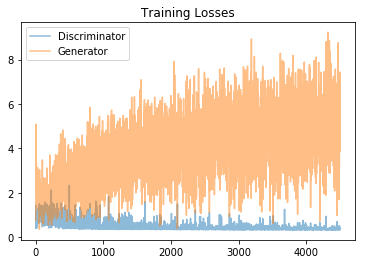

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

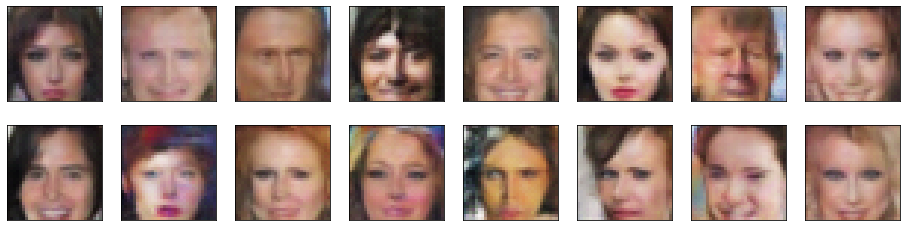

In [24]:
_ = view_samples(-1, samples)

# Improved model

This model will have a higher resolution, and for that an extra transposed convolutional layer is added in the Generator and another extra convolutional layer added in the Discriminator.

Moreover the depth of the conv/dconv are increased to 64.

### Discriminator

In [25]:
class Discriminator64(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # Input of 64x64
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 32x32
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 16x16
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 8x8
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 4x4
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out) # For some reason we end with a 50x1x1x1 tensor...
        return out

### Generator

In [26]:
class Generator64(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        # The first transpose conv layer should have a 4x4 size and depth of 512 = (4*32)
        self.fc = nn.Linear(z_size, conv_dim*4*4*8) 
        # The output of fc will be reshaped into a 4*4*512 vector
        # 4x4
        self.tconv1 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, 4, stride=2, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(conv_dim*2)
        # 8x8
        self.tconv2 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(conv_dim)
        # 16x16
        self.tconv3 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(conv_dim)
        # 32x32
        self.tconv4 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(conv_dim)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        # reshaping the vector to (batchsize, conv depth, 4size, 4size)
        out = out.view(-1, self.conv_dim*4, 4, 4) 
        
        out = F.relu(self.norm1(self.tconv1(out)))
        out = F.relu(self.norm2(self.tconv2(out)))
        out = self.tconv3(out)
        out = F.tanh(out)
        
        return out


In [27]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D64, G64 = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (tconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm1): BatchNo

In [28]:
# set number of epochs 
n_epochs = 50
n_epochs_decay = 10

In [29]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D64.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G64.parameters(), lr, [beta1, beta2])


In [30]:
from torch.optim import lr_scheduler
# Learning rate policy
# Learning rate goes to 0 at the end of the number of 
def lambda_rule(epoch):
    lr_l = 1.0 - max(0, epoch - n_epochs) / float(n_epochs_decay + 1)
    return lr_l

d_scheduler = lr_scheduler.LambdaLR(d_optimizer, lr_lambda=lambda_rule)
g_scheduler = lr_scheduler.LambdaLR(g_optimizer, lr_lambda=lambda_rule)
schedulers = [d_scheduler, g_scheduler]

In [31]:
def update_learning_rate():
    """Update learning rates for all the networks; called at the end of every epoch"""
    for scheduler in schedulers:
        scheduler.step()
    lr = d_optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

### Model 

In [32]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            # 1.1 Real images train
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            
            d_real_loss = real_loss(D_real)
            
            # 1.2 Fake images
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            
            D_fake = D(fake_images)
            
            # compute the fake loss
            d_fake_loss = fake_loss(D_fake)
            
            # final discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # 2.1 Train with
            # Generate fake img
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            D_fake = D(fake_images)
            
            # compute generator loss on fake img
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
            


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
    update_learning_rate()
    # Save training generator samples
    with open('train_samples64.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [33]:
losses = train(D64, G64, n_epochs=n_epochs+n_epochs_decay)

Epoch [    1/   60] | d_loss: 1.3439 | g_loss: 1.1238
Epoch [    1/   60] | d_loss: 0.6580 | g_loss: 4.3346
Epoch [    1/   60] | d_loss: 1.0137 | g_loss: 2.0743
Epoch [    1/   60] | d_loss: 0.9375 | g_loss: 0.9218
Epoch [    1/   60] | d_loss: 0.4651 | g_loss: 3.3810
Epoch [    1/   60] | d_loss: 1.3070 | g_loss: 3.5444
Epoch [    1/   60] | d_loss: 0.8831 | g_loss: 3.0806
Epoch [    1/   60] | d_loss: 0.6759 | g_loss: 2.6185
Epoch [    1/   60] | d_loss: 0.8671 | g_loss: 2.0898
Epoch [    1/   60] | d_loss: 1.0996 | g_loss: 4.3248
Epoch [    1/   60] | d_loss: 0.6824 | g_loss: 4.1631
Epoch [    1/   60] | d_loss: 1.0019 | g_loss: 1.6400
Epoch [    1/   60] | d_loss: 0.6603 | g_loss: 1.8122
Epoch [    1/   60] | d_loss: 0.6927 | g_loss: 4.6281
Epoch [    1/   60] | d_loss: 0.5486 | g_loss: 2.6713
Epoch [    1/   60] | d_loss: 0.6672 | g_loss: 2.7442
Epoch [    1/   60] | d_loss: 1.2957 | g_loss: 0.7879
Epoch [    1/   60] | d_loss: 0.8392 | g_loss: 2.0617
Epoch [    1/   60] | d_loss

Epoch [    2/   60] | d_loss: 0.6904 | g_loss: 1.8524
Epoch [    2/   60] | d_loss: 0.9083 | g_loss: 2.3385
Epoch [    2/   60] | d_loss: 0.6520 | g_loss: 1.9466
Epoch [    2/   60] | d_loss: 0.8125 | g_loss: 2.4511
Epoch [    2/   60] | d_loss: 0.8156 | g_loss: 2.3450
Epoch [    2/   60] | d_loss: 1.0245 | g_loss: 1.9597
Epoch [    2/   60] | d_loss: 0.8854 | g_loss: 2.0264
Epoch [    2/   60] | d_loss: 1.1434 | g_loss: 0.7423
Epoch [    2/   60] | d_loss: 0.7442 | g_loss: 1.9240
Epoch [    2/   60] | d_loss: 0.9649 | g_loss: 1.3501
Epoch [    2/   60] | d_loss: 0.8040 | g_loss: 2.0891
Epoch [    2/   60] | d_loss: 0.6465 | g_loss: 2.2212
Epoch [    2/   60] | d_loss: 0.9561 | g_loss: 1.3200
Epoch [    2/   60] | d_loss: 0.6733 | g_loss: 2.0674
Epoch [    2/   60] | d_loss: 0.7936 | g_loss: 2.1853
Epoch [    2/   60] | d_loss: 1.4919 | g_loss: 0.5050
Epoch [    2/   60] | d_loss: 0.5789 | g_loss: 1.8368
Epoch [    2/   60] | d_loss: 0.6543 | g_loss: 2.7221
Epoch [    2/   60] | d_loss

Epoch [    4/   60] | d_loss: 0.5990 | g_loss: 2.6820
Epoch [    4/   60] | d_loss: 1.1319 | g_loss: 2.4610
Epoch [    4/   60] | d_loss: 1.0547 | g_loss: 1.5079
Epoch [    4/   60] | d_loss: 0.7257 | g_loss: 1.9141
Epoch [    4/   60] | d_loss: 0.6251 | g_loss: 1.5984
Epoch [    4/   60] | d_loss: 0.8390 | g_loss: 2.0181
Epoch [    4/   60] | d_loss: 1.0434 | g_loss: 2.1917
Epoch [    4/   60] | d_loss: 1.1773 | g_loss: 2.6321
Epoch [    4/   60] | d_loss: 0.4815 | g_loss: 2.6415
Epoch [    4/   60] | d_loss: 0.6291 | g_loss: 2.0552
Epoch [    4/   60] | d_loss: 1.3255 | g_loss: 1.8185
Epoch [    4/   60] | d_loss: 0.6173 | g_loss: 2.2313
Epoch [    4/   60] | d_loss: 0.7671 | g_loss: 2.3208
Epoch [    4/   60] | d_loss: 0.5444 | g_loss: 3.2880
Epoch [    4/   60] | d_loss: 0.5678 | g_loss: 2.1093
Epoch [    4/   60] | d_loss: 0.6295 | g_loss: 1.9149
Epoch [    4/   60] | d_loss: 0.5887 | g_loss: 2.9057
Epoch [    4/   60] | d_loss: 0.8741 | g_loss: 2.1221
Epoch [    4/   60] | d_loss

Epoch [    6/   60] | d_loss: 0.4230 | g_loss: 2.9062
Epoch [    6/   60] | d_loss: 0.8439 | g_loss: 3.4918
Epoch [    6/   60] | d_loss: 0.8206 | g_loss: 2.4097
Epoch [    6/   60] | d_loss: 0.7498 | g_loss: 2.6303
Epoch [    6/   60] | d_loss: 0.4395 | g_loss: 3.6721
Epoch [    6/   60] | d_loss: 0.5004 | g_loss: 3.2950
Epoch [    6/   60] | d_loss: 0.6071 | g_loss: 2.3265
Epoch [    6/   60] | d_loss: 0.5907 | g_loss: 2.7801
Epoch [    6/   60] | d_loss: 0.7799 | g_loss: 2.8024
Epoch [    6/   60] | d_loss: 0.4961 | g_loss: 3.4136
Epoch [    6/   60] | d_loss: 0.6644 | g_loss: 2.8060
Epoch [    6/   60] | d_loss: 0.7358 | g_loss: 1.9770
Epoch [    6/   60] | d_loss: 0.4290 | g_loss: 1.8958
Epoch [    6/   60] | d_loss: 0.4577 | g_loss: 3.0770
Epoch [    6/   60] | d_loss: 0.6914 | g_loss: 1.6908
Epoch [    6/   60] | d_loss: 0.6396 | g_loss: 1.2647
Epoch [    6/   60] | d_loss: 0.9332 | g_loss: 1.5871
Epoch [    6/   60] | d_loss: 0.4151 | g_loss: 3.2616
Epoch [    6/   60] | d_loss

Epoch [    7/   60] | d_loss: 0.4636 | g_loss: 2.9579
Epoch [    7/   60] | d_loss: 0.5737 | g_loss: 2.1036
Epoch [    7/   60] | d_loss: 1.1298 | g_loss: 3.3166
Epoch [    7/   60] | d_loss: 0.3942 | g_loss: 4.6225
Epoch [    7/   60] | d_loss: 0.8582 | g_loss: 2.9165
Epoch [    7/   60] | d_loss: 0.5941 | g_loss: 1.9154
Epoch [    7/   60] | d_loss: 0.6276 | g_loss: 1.8969
Epoch [    7/   60] | d_loss: 0.3959 | g_loss: 2.9867
Epoch [    7/   60] | d_loss: 1.1310 | g_loss: 3.2914
Epoch [    7/   60] | d_loss: 0.6646 | g_loss: 1.5502
Epoch [    7/   60] | d_loss: 0.8161 | g_loss: 5.3415
Epoch [    7/   60] | d_loss: 0.4047 | g_loss: 2.2507
Epoch [    7/   60] | d_loss: 0.7584 | g_loss: 1.5550
Epoch [    7/   60] | d_loss: 0.4543 | g_loss: 2.6776
Epoch [    7/   60] | d_loss: 0.4357 | g_loss: 3.9079
Epoch [    7/   60] | d_loss: 0.9454 | g_loss: 2.7334
Epoch [    7/   60] | d_loss: 0.5543 | g_loss: 1.8611
Epoch [    7/   60] | d_loss: 0.4397 | g_loss: 3.4347
Epoch [    7/   60] | d_loss

Epoch [    9/   60] | d_loss: 0.4106 | g_loss: 4.0997
Epoch [    9/   60] | d_loss: 0.4357 | g_loss: 1.7901
Epoch [    9/   60] | d_loss: 0.5084 | g_loss: 1.8932
Epoch [    9/   60] | d_loss: 0.4227 | g_loss: 4.0188
Epoch [    9/   60] | d_loss: 0.6193 | g_loss: 2.4601
Epoch [    9/   60] | d_loss: 0.6217 | g_loss: 1.5051
Epoch [    9/   60] | d_loss: 0.4174 | g_loss: 3.5794
Epoch [    9/   60] | d_loss: 0.4001 | g_loss: 3.7441
Epoch [    9/   60] | d_loss: 0.6183 | g_loss: 3.9536
Epoch [    9/   60] | d_loss: 0.5894 | g_loss: 2.3590
Epoch [    9/   60] | d_loss: 0.3579 | g_loss: 4.1598
Epoch [    9/   60] | d_loss: 0.7738 | g_loss: 3.3015
Epoch [    9/   60] | d_loss: 0.4671 | g_loss: 3.6668
Epoch [    9/   60] | d_loss: 0.4525 | g_loss: 3.9179
Epoch [    9/   60] | d_loss: 0.5510 | g_loss: 3.4815
Epoch [    9/   60] | d_loss: 0.4796 | g_loss: 3.5282
Epoch [    9/   60] | d_loss: 0.4520 | g_loss: 3.7989
Epoch [    9/   60] | d_loss: 0.5915 | g_loss: 4.2754
Epoch [    9/   60] | d_loss

Epoch [   11/   60] | d_loss: 0.4145 | g_loss: 2.1218
Epoch [   11/   60] | d_loss: 0.5266 | g_loss: 3.9215
Epoch [   11/   60] | d_loss: 0.4014 | g_loss: 3.8509
Epoch [   11/   60] | d_loss: 0.5686 | g_loss: 1.7291
Epoch [   11/   60] | d_loss: 0.5291 | g_loss: 4.0343
Epoch [   11/   60] | d_loss: 0.4889 | g_loss: 2.9371
Epoch [   11/   60] | d_loss: 0.5149 | g_loss: 3.0456
Epoch [   11/   60] | d_loss: 0.4901 | g_loss: 2.5676
Epoch [   11/   60] | d_loss: 0.4981 | g_loss: 2.4148
Epoch [   11/   60] | d_loss: 0.5444 | g_loss: 2.6800
Epoch [   11/   60] | d_loss: 0.3756 | g_loss: 4.6768
Epoch [   11/   60] | d_loss: 0.3837 | g_loss: 4.2503
Epoch [   11/   60] | d_loss: 0.4766 | g_loss: 2.5903
Epoch [   11/   60] | d_loss: 0.7779 | g_loss: 1.9884
Epoch [   11/   60] | d_loss: 0.3922 | g_loss: 4.9882
Epoch [   11/   60] | d_loss: 1.1929 | g_loss: 2.4193
Epoch [   11/   60] | d_loss: 0.3840 | g_loss: 3.0859
Epoch [   11/   60] | d_loss: 0.4742 | g_loss: 4.2203
Epoch [   11/   60] | d_loss

Epoch [   12/   60] | d_loss: 0.5597 | g_loss: 2.7315
Epoch [   12/   60] | d_loss: 0.6056 | g_loss: 3.7842
Epoch [   12/   60] | d_loss: 0.6619 | g_loss: 2.9143
Epoch [   12/   60] | d_loss: 0.4392 | g_loss: 4.0051
Epoch [   12/   60] | d_loss: 0.5693 | g_loss: 3.1267
Epoch [   12/   60] | d_loss: 0.4454 | g_loss: 3.3347
Epoch [   12/   60] | d_loss: 0.4924 | g_loss: 2.8444
Epoch [   12/   60] | d_loss: 0.5136 | g_loss: 2.4494
Epoch [   12/   60] | d_loss: 0.3908 | g_loss: 4.4043
Epoch [   12/   60] | d_loss: 0.5268 | g_loss: 4.1381
Epoch [   12/   60] | d_loss: 0.5164 | g_loss: 3.2756
Epoch [   12/   60] | d_loss: 0.3948 | g_loss: 3.7156
Epoch [   12/   60] | d_loss: 0.4076 | g_loss: 2.5518
Epoch [   12/   60] | d_loss: 0.5994 | g_loss: 2.1002
Epoch [   12/   60] | d_loss: 0.4484 | g_loss: 6.6585
Epoch [   12/   60] | d_loss: 0.4432 | g_loss: 6.0019
Epoch [   12/   60] | d_loss: 0.3649 | g_loss: 6.2058
Epoch [   12/   60] | d_loss: 0.4841 | g_loss: 3.4447
Epoch [   12/   60] | d_loss

Epoch [   14/   60] | d_loss: 0.4708 | g_loss: 1.8757
Epoch [   14/   60] | d_loss: 0.5682 | g_loss: 4.1912
Epoch [   14/   60] | d_loss: 0.3962 | g_loss: 3.8194
Epoch [   14/   60] | d_loss: 0.8036 | g_loss: 2.2044
Epoch [   14/   60] | d_loss: 0.3807 | g_loss: 4.2682
Epoch [   14/   60] | d_loss: 0.4397 | g_loss: 4.4359
Epoch [   14/   60] | d_loss: 0.3540 | g_loss: 3.1314
Epoch [   14/   60] | d_loss: 0.3575 | g_loss: 4.6654
Epoch [   14/   60] | d_loss: 0.4813 | g_loss: 2.5629
Epoch [   14/   60] | d_loss: 0.4095 | g_loss: 4.6901
Epoch [   14/   60] | d_loss: 0.4564 | g_loss: 2.4239
Epoch [   14/   60] | d_loss: 0.4177 | g_loss: 4.1955
Epoch [   14/   60] | d_loss: 0.3577 | g_loss: 5.9730
Epoch [   14/   60] | d_loss: 0.4086 | g_loss: 3.7002
Epoch [   14/   60] | d_loss: 0.4428 | g_loss: 3.1162
Epoch [   14/   60] | d_loss: 0.4150 | g_loss: 4.1556
Epoch [   14/   60] | d_loss: 0.4294 | g_loss: 4.8070
Epoch [   14/   60] | d_loss: 0.4230 | g_loss: 3.9924
Epoch [   14/   60] | d_loss

Epoch [   16/   60] | d_loss: 0.3719 | g_loss: 5.3093
Epoch [   16/   60] | d_loss: 0.3712 | g_loss: 6.2264
Epoch [   16/   60] | d_loss: 0.4609 | g_loss: 2.9731
Epoch [   16/   60] | d_loss: 0.5293 | g_loss: 3.1424
Epoch [   16/   60] | d_loss: 0.4596 | g_loss: 4.4421
Epoch [   16/   60] | d_loss: 0.5696 | g_loss: 1.4177
Epoch [   16/   60] | d_loss: 0.4947 | g_loss: 2.9996
Epoch [   16/   60] | d_loss: 0.4246 | g_loss: 4.2534
Epoch [   16/   60] | d_loss: 0.3569 | g_loss: 4.2260
Epoch [   16/   60] | d_loss: 0.4182 | g_loss: 1.4816
Epoch [   16/   60] | d_loss: 0.3887 | g_loss: 4.8190
Epoch [   16/   60] | d_loss: 0.4461 | g_loss: 3.5356
Epoch [   16/   60] | d_loss: 0.5026 | g_loss: 4.2600
Epoch [   16/   60] | d_loss: 0.4956 | g_loss: 3.9399
Epoch [   16/   60] | d_loss: 0.4892 | g_loss: 3.5787
Epoch [   16/   60] | d_loss: 0.4751 | g_loss: 3.6360
Epoch [   16/   60] | d_loss: 0.4214 | g_loss: 4.4227
Epoch [   16/   60] | d_loss: 0.4189 | g_loss: 5.3762
Epoch [   16/   60] | d_loss

Epoch [   17/   60] | d_loss: 1.2968 | g_loss: 1.2900
Epoch [   17/   60] | d_loss: 0.3705 | g_loss: 3.9235
Epoch [   17/   60] | d_loss: 0.3863 | g_loss: 4.8274
Epoch [   17/   60] | d_loss: 0.3556 | g_loss: 7.6797
Epoch [   17/   60] | d_loss: 0.4275 | g_loss: 5.1086
Epoch [   17/   60] | d_loss: 0.4118 | g_loss: 4.2993
Epoch [   17/   60] | d_loss: 0.4038 | g_loss: 3.5770
Epoch [   17/   60] | d_loss: 0.3697 | g_loss: 3.1188
Epoch [   17/   60] | d_loss: 0.4133 | g_loss: 4.8336
Epoch [   17/   60] | d_loss: 0.4156 | g_loss: 4.8774
Epoch [   17/   60] | d_loss: 0.3456 | g_loss: 3.6112
Epoch [   17/   60] | d_loss: 0.4750 | g_loss: 3.7250
Epoch [   17/   60] | d_loss: 0.5841 | g_loss: 3.0720
Epoch [   17/   60] | d_loss: 0.3899 | g_loss: 1.9726
Epoch [   17/   60] | d_loss: 0.5451 | g_loss: 3.2085
Epoch [   17/   60] | d_loss: 0.4119 | g_loss: 4.7413
Epoch [   17/   60] | d_loss: 0.3785 | g_loss: 4.0846
Epoch [   17/   60] | d_loss: 0.8784 | g_loss: 1.9777
Epoch [   17/   60] | d_loss

Epoch [   19/   60] | d_loss: 0.5417 | g_loss: 4.4261
Epoch [   19/   60] | d_loss: 0.4127 | g_loss: 4.2895
Epoch [   19/   60] | d_loss: 0.3640 | g_loss: 4.0791
Epoch [   19/   60] | d_loss: 0.4100 | g_loss: 3.9024
Epoch [   19/   60] | d_loss: 0.4171 | g_loss: 3.2042
Epoch [   19/   60] | d_loss: 0.4014 | g_loss: 5.1717
Epoch [   19/   60] | d_loss: 0.4699 | g_loss: 3.5031
Epoch [   19/   60] | d_loss: 0.3853 | g_loss: 3.0789
Epoch [   19/   60] | d_loss: 0.4400 | g_loss: 3.5240
Epoch [   19/   60] | d_loss: 0.3564 | g_loss: 5.6196
Epoch [   19/   60] | d_loss: 0.4744 | g_loss: 3.3498
Epoch [   19/   60] | d_loss: 0.3981 | g_loss: 5.3469
Epoch [   19/   60] | d_loss: 0.3794 | g_loss: 2.6237
Epoch [   19/   60] | d_loss: 0.3805 | g_loss: 5.4567
Epoch [   19/   60] | d_loss: 0.3504 | g_loss: 4.1139
Epoch [   19/   60] | d_loss: 0.3497 | g_loss: 4.2659
Epoch [   19/   60] | d_loss: 0.4665 | g_loss: 3.4842
Epoch [   19/   60] | d_loss: 0.4710 | g_loss: 2.3109
Epoch [   19/   60] | d_loss

Epoch [   21/   60] | d_loss: 0.5323 | g_loss: 4.6260
Epoch [   21/   60] | d_loss: 0.4337 | g_loss: 2.8488
Epoch [   21/   60] | d_loss: 0.4578 | g_loss: 3.5660
Epoch [   21/   60] | d_loss: 0.7116 | g_loss: 2.3021
Epoch [   21/   60] | d_loss: 0.3869 | g_loss: 4.9553
Epoch [   21/   60] | d_loss: 0.4774 | g_loss: 4.0373
Epoch [   21/   60] | d_loss: 0.3523 | g_loss: 4.3944
Epoch [   21/   60] | d_loss: 0.3744 | g_loss: 4.8423
Epoch [   21/   60] | d_loss: 0.3802 | g_loss: 3.1698
Epoch [   21/   60] | d_loss: 0.4040 | g_loss: 3.1451
Epoch [   21/   60] | d_loss: 0.4243 | g_loss: 4.3353
Epoch [   21/   60] | d_loss: 1.3220 | g_loss: 4.9092
Epoch [   21/   60] | d_loss: 0.4993 | g_loss: 4.7421
Epoch [   21/   60] | d_loss: 0.5421 | g_loss: 2.4816
Epoch [   21/   60] | d_loss: 0.4451 | g_loss: 4.3377
Epoch [   21/   60] | d_loss: 0.3581 | g_loss: 4.4313
Epoch [   21/   60] | d_loss: 0.4202 | g_loss: 4.3073
Epoch [   21/   60] | d_loss: 0.4125 | g_loss: 2.8984
Epoch [   21/   60] | d_loss

Epoch [   22/   60] | d_loss: 0.4745 | g_loss: 1.8331
Epoch [   22/   60] | d_loss: 0.3844 | g_loss: 3.4854
Epoch [   22/   60] | d_loss: 0.3648 | g_loss: 4.8151
Epoch [   22/   60] | d_loss: 0.3675 | g_loss: 4.6534
Epoch [   22/   60] | d_loss: 0.3440 | g_loss: 3.1249
Epoch [   22/   60] | d_loss: 0.3566 | g_loss: 4.4989
Epoch [   22/   60] | d_loss: 0.3684 | g_loss: 4.9966
Epoch [   22/   60] | d_loss: 0.3464 | g_loss: 8.7403
Epoch [   22/   60] | d_loss: 0.4349 | g_loss: 3.7874
Epoch [   22/   60] | d_loss: 0.3769 | g_loss: 2.0760
Epoch [   22/   60] | d_loss: 0.3864 | g_loss: 6.1810
Epoch [   22/   60] | d_loss: 0.4426 | g_loss: 4.7338
Epoch [   22/   60] | d_loss: 0.3832 | g_loss: 3.4900
Epoch [   22/   60] | d_loss: 0.4634 | g_loss: 4.1076
Epoch [   22/   60] | d_loss: 0.3575 | g_loss: 5.7894
Epoch [   22/   60] | d_loss: 0.5826 | g_loss: 2.9121
Epoch [   22/   60] | d_loss: 0.4054 | g_loss: 3.8523
Epoch [   23/   60] | d_loss: 0.4924 | g_loss: 4.9298
Epoch [   23/   60] | d_loss

Epoch [   24/   60] | d_loss: 0.4403 | g_loss: 5.3318
Epoch [   24/   60] | d_loss: 0.5853 | g_loss: 3.8759
Epoch [   24/   60] | d_loss: 0.3585 | g_loss: 4.3247
Epoch [   24/   60] | d_loss: 0.4891 | g_loss: 2.4411
Epoch [   24/   60] | d_loss: 0.3702 | g_loss: 4.0100
Epoch [   24/   60] | d_loss: 0.3802 | g_loss: 4.5567
Epoch [   24/   60] | d_loss: 0.7582 | g_loss: 4.1139
Epoch [   24/   60] | d_loss: 0.3841 | g_loss: 4.4698
Epoch [   24/   60] | d_loss: 0.3899 | g_loss: 4.8130
Epoch [   24/   60] | d_loss: 0.4549 | g_loss: 6.2122
Epoch [   24/   60] | d_loss: 0.4153 | g_loss: 6.2562
Epoch [   24/   60] | d_loss: 0.4746 | g_loss: 4.0527
Epoch [   24/   60] | d_loss: 0.4533 | g_loss: 4.8148
Epoch [   24/   60] | d_loss: 0.3803 | g_loss: 5.1540
Epoch [   24/   60] | d_loss: 0.4184 | g_loss: 3.9766
Epoch [   24/   60] | d_loss: 0.3787 | g_loss: 5.1769
Epoch [   24/   60] | d_loss: 0.3893 | g_loss: 5.1789
Epoch [   24/   60] | d_loss: 0.3746 | g_loss: 4.3604
Epoch [   24/   60] | d_loss

Epoch [   26/   60] | d_loss: 0.4901 | g_loss: 3.3954
Epoch [   26/   60] | d_loss: 0.4245 | g_loss: 4.5557
Epoch [   26/   60] | d_loss: 0.4127 | g_loss: 4.2509
Epoch [   26/   60] | d_loss: 0.3787 | g_loss: 5.5170
Epoch [   26/   60] | d_loss: 0.4677 | g_loss: 5.3968
Epoch [   26/   60] | d_loss: 0.3774 | g_loss: 4.4878
Epoch [   26/   60] | d_loss: 0.3706 | g_loss: 3.0945
Epoch [   26/   60] | d_loss: 0.3796 | g_loss: 3.0677
Epoch [   26/   60] | d_loss: 0.4985 | g_loss: 3.6390
Epoch [   26/   60] | d_loss: 0.3784 | g_loss: 3.4644
Epoch [   26/   60] | d_loss: 0.3582 | g_loss: 5.8949
Epoch [   26/   60] | d_loss: 0.4447 | g_loss: 5.2694
Epoch [   26/   60] | d_loss: 0.7161 | g_loss: 2.0933
Epoch [   26/   60] | d_loss: 0.3829 | g_loss: 5.0161
Epoch [   26/   60] | d_loss: 0.4557 | g_loss: 3.6081
Epoch [   26/   60] | d_loss: 0.4726 | g_loss: 5.7439
Epoch [   26/   60] | d_loss: 0.3502 | g_loss: 6.3252
Epoch [   26/   60] | d_loss: 0.3605 | g_loss: 4.6314
Epoch [   26/   60] | d_loss

Epoch [   27/   60] | d_loss: 0.3941 | g_loss: 5.9941
Epoch [   27/   60] | d_loss: 0.4017 | g_loss: 4.6800
Epoch [   27/   60] | d_loss: 0.3490 | g_loss: 4.9126
Epoch [   27/   60] | d_loss: 0.3725 | g_loss: 4.8150
Epoch [   27/   60] | d_loss: 0.3903 | g_loss: 2.0069
Epoch [   27/   60] | d_loss: 0.3592 | g_loss: 4.0894
Epoch [   27/   60] | d_loss: 0.3857 | g_loss: 3.1663
Epoch [   27/   60] | d_loss: 0.3392 | g_loss: 5.9602
Epoch [   27/   60] | d_loss: 0.3962 | g_loss: 4.5342
Epoch [   27/   60] | d_loss: 0.3879 | g_loss: 5.5253
Epoch [   27/   60] | d_loss: 0.4142 | g_loss: 4.2706
Epoch [   27/   60] | d_loss: 0.4209 | g_loss: 4.9465
Epoch [   27/   60] | d_loss: 0.3547 | g_loss: 4.2176
Epoch [   27/   60] | d_loss: 0.3663 | g_loss: 4.6186
Epoch [   28/   60] | d_loss: 0.3525 | g_loss: 5.2570
Epoch [   28/   60] | d_loss: 0.4049 | g_loss: 3.4515
Epoch [   28/   60] | d_loss: 0.3900 | g_loss: 6.3560
Epoch [   28/   60] | d_loss: 0.3713 | g_loss: 3.9784
Epoch [   28/   60] | d_loss

Epoch [   29/   60] | d_loss: 0.5731 | g_loss: 3.1048
Epoch [   29/   60] | d_loss: 0.5760 | g_loss: 3.4347
Epoch [   29/   60] | d_loss: 0.5797 | g_loss: 4.2257
Epoch [   29/   60] | d_loss: 0.3581 | g_loss: 4.5447
Epoch [   29/   60] | d_loss: 0.3619 | g_loss: 4.6476
Epoch [   29/   60] | d_loss: 0.3466 | g_loss: 6.0927
Epoch [   29/   60] | d_loss: 0.3752 | g_loss: 3.4224
Epoch [   29/   60] | d_loss: 0.5139 | g_loss: 5.9010
Epoch [   29/   60] | d_loss: 0.4443 | g_loss: 3.5256
Epoch [   29/   60] | d_loss: 0.3853 | g_loss: 3.6687
Epoch [   29/   60] | d_loss: 0.3897 | g_loss: 4.3481
Epoch [   29/   60] | d_loss: 0.3758 | g_loss: 5.6212
Epoch [   29/   60] | d_loss: 0.4361 | g_loss: 3.5621
Epoch [   29/   60] | d_loss: 0.4061 | g_loss: 3.3406
Epoch [   29/   60] | d_loss: 0.4117 | g_loss: 5.1562
Epoch [   29/   60] | d_loss: 0.3769 | g_loss: 3.7896
Epoch [   29/   60] | d_loss: 0.4043 | g_loss: 4.0594
Epoch [   29/   60] | d_loss: 0.3666 | g_loss: 6.8341
Epoch [   29/   60] | d_loss

Epoch [   31/   60] | d_loss: 0.4839 | g_loss: 3.9683
Epoch [   31/   60] | d_loss: 0.4387 | g_loss: 4.7023
Epoch [   31/   60] | d_loss: 0.3560 | g_loss: 7.3256
Epoch [   31/   60] | d_loss: 0.3561 | g_loss: 5.6011
Epoch [   31/   60] | d_loss: 0.3493 | g_loss: 6.8919
Epoch [   31/   60] | d_loss: 0.4553 | g_loss: 2.1164
Epoch [   31/   60] | d_loss: 0.4620 | g_loss: 3.8892
Epoch [   31/   60] | d_loss: 0.4755 | g_loss: 3.9089
Epoch [   31/   60] | d_loss: 0.4216 | g_loss: 2.9769
Epoch [   31/   60] | d_loss: 0.3481 | g_loss: 3.5104
Epoch [   31/   60] | d_loss: 0.6023 | g_loss: 1.7180
Epoch [   31/   60] | d_loss: 0.3560 | g_loss: 4.5594
Epoch [   31/   60] | d_loss: 0.3915 | g_loss: 2.9151
Epoch [   31/   60] | d_loss: 0.5165 | g_loss: 3.6944
Epoch [   31/   60] | d_loss: 0.3374 | g_loss: 6.1786
Epoch [   31/   60] | d_loss: 0.4216 | g_loss: 4.8808
Epoch [   31/   60] | d_loss: 0.3606 | g_loss: 5.3935
Epoch [   31/   60] | d_loss: 0.3694 | g_loss: 3.4876
Epoch [   31/   60] | d_loss

Epoch [   32/   60] | d_loss: 0.4466 | g_loss: 2.6976
Epoch [   32/   60] | d_loss: 0.3647 | g_loss: 5.1429
Epoch [   32/   60] | d_loss: 0.5283 | g_loss: 3.4942
Epoch [   32/   60] | d_loss: 0.4109 | g_loss: 2.4751
Epoch [   32/   60] | d_loss: 0.3691 | g_loss: 4.2123
Epoch [   32/   60] | d_loss: 0.3613 | g_loss: 5.4295
Epoch [   32/   60] | d_loss: 0.3608 | g_loss: 5.3490
Epoch [   32/   60] | d_loss: 0.4307 | g_loss: 3.7670
Epoch [   32/   60] | d_loss: 0.4839 | g_loss: 7.4108
Epoch [   32/   60] | d_loss: 0.3499 | g_loss: 7.1861
Epoch [   32/   60] | d_loss: 0.3768 | g_loss: 4.8084
Epoch [   33/   60] | d_loss: 0.4953 | g_loss: 3.3991
Epoch [   33/   60] | d_loss: 0.3701 | g_loss: 5.6115
Epoch [   33/   60] | d_loss: 0.3709 | g_loss: 5.4609
Epoch [   33/   60] | d_loss: 0.6218 | g_loss: 3.4327
Epoch [   33/   60] | d_loss: 0.3679 | g_loss: 4.3856
Epoch [   33/   60] | d_loss: 0.3691 | g_loss: 5.6476
Epoch [   33/   60] | d_loss: 0.3851 | g_loss: 3.0865
Epoch [   33/   60] | d_loss

Epoch [   34/   60] | d_loss: 0.5448 | g_loss: 4.7102
Epoch [   34/   60] | d_loss: 0.4030 | g_loss: 4.5389
Epoch [   34/   60] | d_loss: 0.4858 | g_loss: 2.3709
Epoch [   34/   60] | d_loss: 0.5132 | g_loss: 5.5576
Epoch [   34/   60] | d_loss: 0.3863 | g_loss: 6.7047
Epoch [   34/   60] | d_loss: 0.3574 | g_loss: 4.5058
Epoch [   34/   60] | d_loss: 0.3691 | g_loss: 4.1240
Epoch [   34/   60] | d_loss: 0.3441 | g_loss: 3.2090
Epoch [   34/   60] | d_loss: 0.5875 | g_loss: 2.3948
Epoch [   34/   60] | d_loss: 0.4263 | g_loss: 4.9356
Epoch [   34/   60] | d_loss: 0.4567 | g_loss: 3.0057
Epoch [   34/   60] | d_loss: 0.5528 | g_loss: 4.3319
Epoch [   34/   60] | d_loss: 0.3901 | g_loss: 4.3290
Epoch [   34/   60] | d_loss: 0.3404 | g_loss: 6.6982
Epoch [   34/   60] | d_loss: 0.4641 | g_loss: 2.4998
Epoch [   34/   60] | d_loss: 0.3663 | g_loss: 6.1231
Epoch [   34/   60] | d_loss: 0.3394 | g_loss: 5.7517
Epoch [   34/   60] | d_loss: 0.4487 | g_loss: 6.1291
Epoch [   34/   60] | d_loss

Epoch [   36/   60] | d_loss: 0.3674 | g_loss: 4.2317
Epoch [   36/   60] | d_loss: 0.3924 | g_loss: 6.2065
Epoch [   36/   60] | d_loss: 0.3428 | g_loss: 6.3761
Epoch [   36/   60] | d_loss: 0.3466 | g_loss: 3.5212
Epoch [   36/   60] | d_loss: 0.3457 | g_loss: 1.5754
Epoch [   36/   60] | d_loss: 0.3637 | g_loss: 4.6735
Epoch [   36/   60] | d_loss: 0.3445 | g_loss: 4.4159
Epoch [   36/   60] | d_loss: 0.3432 | g_loss: 4.9471
Epoch [   36/   60] | d_loss: 0.4422 | g_loss: 4.4384
Epoch [   36/   60] | d_loss: 0.3647 | g_loss: 5.5184
Epoch [   36/   60] | d_loss: 0.3942 | g_loss: 3.1753
Epoch [   36/   60] | d_loss: 0.4060 | g_loss: 6.2304
Epoch [   36/   60] | d_loss: 0.3955 | g_loss: 4.5960
Epoch [   36/   60] | d_loss: 0.4019 | g_loss: 4.8284
Epoch [   36/   60] | d_loss: 0.3433 | g_loss: 4.0218
Epoch [   36/   60] | d_loss: 0.3769 | g_loss: 5.8653
Epoch [   36/   60] | d_loss: 0.3680 | g_loss: 8.7365
Epoch [   36/   60] | d_loss: 0.3933 | g_loss: 4.6828
Epoch [   36/   60] | d_loss

Epoch [   37/   60] | d_loss: 0.3523 | g_loss: 5.2795
Epoch [   37/   60] | d_loss: 0.3871 | g_loss: 4.8444
Epoch [   37/   60] | d_loss: 0.3469 | g_loss: 4.9971
Epoch [   37/   60] | d_loss: 0.4124 | g_loss: 4.0247
Epoch [   37/   60] | d_loss: 0.4817 | g_loss: 3.0951
Epoch [   37/   60] | d_loss: 0.4011 | g_loss: 3.7033
Epoch [   37/   60] | d_loss: 0.3841 | g_loss: 2.8401
Epoch [   37/   60] | d_loss: 0.3569 | g_loss: 7.9052
Epoch [   38/   60] | d_loss: 0.4229 | g_loss: 5.8154
Epoch [   38/   60] | d_loss: 0.3540 | g_loss: 3.6640
Epoch [   38/   60] | d_loss: 0.7033 | g_loss: 1.6405
Epoch [   38/   60] | d_loss: 0.5848 | g_loss: 4.6486
Epoch [   38/   60] | d_loss: 0.3777 | g_loss: 3.8374
Epoch [   38/   60] | d_loss: 0.3389 | g_loss: 4.1942
Epoch [   38/   60] | d_loss: 0.3961 | g_loss: 4.6570
Epoch [   38/   60] | d_loss: 0.3479 | g_loss: 6.6833
Epoch [   38/   60] | d_loss: 0.3684 | g_loss: 4.3498
Epoch [   38/   60] | d_loss: 0.3699 | g_loss: 4.4888
Epoch [   38/   60] | d_loss

Epoch [   39/   60] | d_loss: 0.4213 | g_loss: 4.8729
Epoch [   39/   60] | d_loss: 0.5567 | g_loss: 2.6015
Epoch [   39/   60] | d_loss: 0.3965 | g_loss: 3.5387
Epoch [   39/   60] | d_loss: 0.3514 | g_loss: 5.7348
Epoch [   39/   60] | d_loss: 0.3432 | g_loss: 3.4042
Epoch [   39/   60] | d_loss: 0.3644 | g_loss: 6.0404
Epoch [   39/   60] | d_loss: 0.3532 | g_loss: 4.1820
Epoch [   39/   60] | d_loss: 0.5160 | g_loss: 7.2491
Epoch [   39/   60] | d_loss: 0.4230 | g_loss: 4.5125
Epoch [   39/   60] | d_loss: 0.3675 | g_loss: 4.2522
Epoch [   39/   60] | d_loss: 0.3607 | g_loss: 5.5014
Epoch [   39/   60] | d_loss: 0.3997 | g_loss: 5.4500
Epoch [   39/   60] | d_loss: 0.3778 | g_loss: 5.0881
Epoch [   39/   60] | d_loss: 0.3814 | g_loss: 3.7483
Epoch [   39/   60] | d_loss: 0.3448 | g_loss: 7.1126
Epoch [   39/   60] | d_loss: 0.3730 | g_loss: 6.0830
Epoch [   39/   60] | d_loss: 0.3380 | g_loss: 5.4687
Epoch [   39/   60] | d_loss: 0.4507 | g_loss: 4.0797
Epoch [   39/   60] | d_loss

Epoch [   41/   60] | d_loss: 0.4139 | g_loss: 4.8242
Epoch [   41/   60] | d_loss: 0.4139 | g_loss: 4.5057
Epoch [   41/   60] | d_loss: 0.3936 | g_loss: 4.9235
Epoch [   41/   60] | d_loss: 0.3809 | g_loss: 5.8821
Epoch [   41/   60] | d_loss: 0.3563 | g_loss: 4.5738
Epoch [   41/   60] | d_loss: 0.3430 | g_loss: 4.8107
Epoch [   41/   60] | d_loss: 0.4203 | g_loss: 4.5016
Epoch [   41/   60] | d_loss: 0.3664 | g_loss: 4.7013
Epoch [   41/   60] | d_loss: 0.3622 | g_loss: 4.4827
Epoch [   41/   60] | d_loss: 0.3876 | g_loss: 2.6758
Epoch [   41/   60] | d_loss: 0.3501 | g_loss: 6.4683
Epoch [   41/   60] | d_loss: 0.3549 | g_loss: 5.1732
Epoch [   41/   60] | d_loss: 0.3440 | g_loss: 7.7140
Epoch [   41/   60] | d_loss: 0.3675 | g_loss: 6.2262
Epoch [   41/   60] | d_loss: 0.3586 | g_loss: 5.9284
Epoch [   41/   60] | d_loss: 0.3456 | g_loss: 3.0998
Epoch [   41/   60] | d_loss: 0.3741 | g_loss: 4.3241
Epoch [   41/   60] | d_loss: 0.8590 | g_loss: 1.0050
Epoch [   41/   60] | d_loss

Epoch [   42/   60] | d_loss: 0.4236 | g_loss: 3.5917
Epoch [   42/   60] | d_loss: 0.3727 | g_loss: 4.5768
Epoch [   42/   60] | d_loss: 0.3534 | g_loss: 4.1744
Epoch [   42/   60] | d_loss: 0.8853 | g_loss: 3.1812
Epoch [   42/   60] | d_loss: 0.3705 | g_loss: 5.8048
Epoch [   43/   60] | d_loss: 0.3459 | g_loss: 3.7453
Epoch [   43/   60] | d_loss: 0.3382 | g_loss: 5.0410
Epoch [   43/   60] | d_loss: 0.3607 | g_loss: 2.8805
Epoch [   43/   60] | d_loss: 0.4124 | g_loss: 4.5249
Epoch [   43/   60] | d_loss: 0.3875 | g_loss: 5.2360
Epoch [   43/   60] | d_loss: 0.5223 | g_loss: 3.5195
Epoch [   43/   60] | d_loss: 0.4051 | g_loss: 5.0618
Epoch [   43/   60] | d_loss: 0.3480 | g_loss: 5.9770
Epoch [   43/   60] | d_loss: 0.3543 | g_loss: 5.7250
Epoch [   43/   60] | d_loss: 0.3437 | g_loss: 3.8425
Epoch [   43/   60] | d_loss: 0.7786 | g_loss: 3.8080
Epoch [   43/   60] | d_loss: 0.3401 | g_loss: 6.9238
Epoch [   43/   60] | d_loss: 0.3504 | g_loss: 5.4402
Epoch [   43/   60] | d_loss

Epoch [   44/   60] | d_loss: 0.5178 | g_loss: 4.9682
Epoch [   44/   60] | d_loss: 0.4570 | g_loss: 5.3649
Epoch [   44/   60] | d_loss: 0.4045 | g_loss: 3.4749
Epoch [   44/   60] | d_loss: 0.3694 | g_loss: 3.3340
Epoch [   44/   60] | d_loss: 0.4377 | g_loss: 4.6047
Epoch [   44/   60] | d_loss: 0.5536 | g_loss: 4.8141
Epoch [   44/   60] | d_loss: 0.3617 | g_loss: 7.1914
Epoch [   44/   60] | d_loss: 0.3693 | g_loss: 5.5107
Epoch [   44/   60] | d_loss: 0.3623 | g_loss: 5.4953
Epoch [   44/   60] | d_loss: 0.3543 | g_loss: 3.9895
Epoch [   44/   60] | d_loss: 0.4190 | g_loss: 4.4748
Epoch [   44/   60] | d_loss: 0.3713 | g_loss: 6.2413
Epoch [   44/   60] | d_loss: 0.3380 | g_loss: 4.5215
Epoch [   44/   60] | d_loss: 0.3357 | g_loss: 3.5969
Epoch [   44/   60] | d_loss: 0.3763 | g_loss: 6.3374
Epoch [   44/   60] | d_loss: 0.3424 | g_loss: 5.6821
Epoch [   44/   60] | d_loss: 0.3859 | g_loss: 5.0450
Epoch [   44/   60] | d_loss: 0.3411 | g_loss: 6.9519
Epoch [   44/   60] | d_loss

Epoch [   46/   60] | d_loss: 0.3557 | g_loss: 5.6049
Epoch [   46/   60] | d_loss: 0.3713 | g_loss: 3.9221
Epoch [   46/   60] | d_loss: 0.4326 | g_loss: 4.7071
Epoch [   46/   60] | d_loss: 0.3927 | g_loss: 5.7972
Epoch [   46/   60] | d_loss: 0.4568 | g_loss: 5.9211
Epoch [   46/   60] | d_loss: 0.3509 | g_loss: 3.0311
Epoch [   46/   60] | d_loss: 0.3608 | g_loss: 5.4895
Epoch [   46/   60] | d_loss: 0.3466 | g_loss: 5.8605
Epoch [   46/   60] | d_loss: 0.3463 | g_loss: 4.7940
Epoch [   46/   60] | d_loss: 0.3440 | g_loss: 6.1283
Epoch [   46/   60] | d_loss: 0.3384 | g_loss: 4.1767
Epoch [   46/   60] | d_loss: 0.4044 | g_loss: 7.0378
Epoch [   46/   60] | d_loss: 0.3884 | g_loss: 5.3933
Epoch [   46/   60] | d_loss: 0.3810 | g_loss: 8.0601
Epoch [   46/   60] | d_loss: 0.3613 | g_loss: 3.6916
Epoch [   46/   60] | d_loss: 0.3481 | g_loss: 4.3942
Epoch [   46/   60] | d_loss: 0.3562 | g_loss: 7.6481
Epoch [   46/   60] | d_loss: 0.3443 | g_loss: 5.1868
Epoch [   46/   60] | d_loss

Epoch [   47/   60] | d_loss: 0.4058 | g_loss: 4.8013
Epoch [   47/   60] | d_loss: 0.3519 | g_loss: 5.5293
Epoch [   48/   60] | d_loss: 0.9866 | g_loss: 5.2564
Epoch [   48/   60] | d_loss: 0.3438 | g_loss: 5.4624
Epoch [   48/   60] | d_loss: 0.3447 | g_loss: 5.0301
Epoch [   48/   60] | d_loss: 0.3504 | g_loss: 5.2187
Epoch [   48/   60] | d_loss: 0.3445 | g_loss: 5.2381
Epoch [   48/   60] | d_loss: 0.3488 | g_loss: 4.2354
Epoch [   48/   60] | d_loss: 0.3557 | g_loss: 4.2337
Epoch [   48/   60] | d_loss: 0.4437 | g_loss: 3.9883
Epoch [   48/   60] | d_loss: 0.3562 | g_loss: 6.0468
Epoch [   48/   60] | d_loss: 0.3862 | g_loss: 4.7035
Epoch [   48/   60] | d_loss: 0.4082 | g_loss: 5.0351
Epoch [   48/   60] | d_loss: 0.3471 | g_loss: 5.1727
Epoch [   48/   60] | d_loss: 0.3548 | g_loss: 6.1196
Epoch [   48/   60] | d_loss: 0.3428 | g_loss: 7.4200
Epoch [   48/   60] | d_loss: 0.3557 | g_loss: 6.3814
Epoch [   48/   60] | d_loss: 0.3428 | g_loss: 4.4528
Epoch [   48/   60] | d_loss

Epoch [   49/   60] | d_loss: 0.3427 | g_loss: 6.2080
Epoch [   49/   60] | d_loss: 0.3367 | g_loss: 8.0919
Epoch [   49/   60] | d_loss: 0.3572 | g_loss: 5.7140
Epoch [   49/   60] | d_loss: 0.3504 | g_loss: 4.4185
Epoch [   49/   60] | d_loss: 0.3431 | g_loss: 6.2870
Epoch [   49/   60] | d_loss: 0.4131 | g_loss: 4.0074
Epoch [   49/   60] | d_loss: 0.3640 | g_loss: 6.8947
Epoch [   49/   60] | d_loss: 0.3798 | g_loss: 3.8355
Epoch [   49/   60] | d_loss: 0.3445 | g_loss: 6.7016
Epoch [   49/   60] | d_loss: 0.3583 | g_loss: 6.0450
Epoch [   49/   60] | d_loss: 0.4832 | g_loss: 3.4411
Epoch [   49/   60] | d_loss: 0.4044 | g_loss: 4.3448
Epoch [   49/   60] | d_loss: 0.3543 | g_loss: 6.9594
Epoch [   49/   60] | d_loss: 0.3587 | g_loss: 6.2050
Epoch [   49/   60] | d_loss: 0.3907 | g_loss: 3.8945
Epoch [   49/   60] | d_loss: 0.4168 | g_loss: 4.9536
Epoch [   49/   60] | d_loss: 0.4649 | g_loss: 2.9897
Epoch [   49/   60] | d_loss: 0.3669 | g_loss: 6.8202
Epoch [   49/   60] | d_loss

Epoch [   51/   60] | d_loss: 0.3712 | g_loss: 4.7193
Epoch [   51/   60] | d_loss: 0.3348 | g_loss: 5.5315
Epoch [   51/   60] | d_loss: 0.3633 | g_loss: 5.0224
Epoch [   51/   60] | d_loss: 0.5265 | g_loss: 2.4107
Epoch [   51/   60] | d_loss: 0.3644 | g_loss: 3.8421
Epoch [   51/   60] | d_loss: 0.5372 | g_loss: 3.9938
Epoch [   51/   60] | d_loss: 0.3467 | g_loss: 6.6565
Epoch [   51/   60] | d_loss: 0.3805 | g_loss: 5.1059
Epoch [   51/   60] | d_loss: 0.3385 | g_loss: 3.8578
Epoch [   51/   60] | d_loss: 0.3613 | g_loss: 4.9176
Epoch [   51/   60] | d_loss: 0.3351 | g_loss: 5.6410
Epoch [   51/   60] | d_loss: 0.3898 | g_loss: 4.0553
Epoch [   51/   60] | d_loss: 0.6805 | g_loss: 2.4519
Epoch [   51/   60] | d_loss: 0.5052 | g_loss: 4.0251
Epoch [   51/   60] | d_loss: 0.3642 | g_loss: 4.2394
Epoch [   51/   60] | d_loss: 0.3491 | g_loss: 9.6844
Epoch [   51/   60] | d_loss: 0.3380 | g_loss: 6.5435
Epoch [   51/   60] | d_loss: 0.3617 | g_loss: 5.6460
Epoch [   51/   60] | d_loss

Epoch [   53/   60] | d_loss: 0.3676 | g_loss: 4.0907
Epoch [   53/   60] | d_loss: 0.5184 | g_loss: 2.7491
Epoch [   53/   60] | d_loss: 0.4039 | g_loss: 3.6511
Epoch [   53/   60] | d_loss: 0.3938 | g_loss: 3.8045
Epoch [   53/   60] | d_loss: 0.4370 | g_loss: 2.9395
Epoch [   53/   60] | d_loss: 0.3557 | g_loss: 4.9403
Epoch [   53/   60] | d_loss: 0.3632 | g_loss: 2.7348
Epoch [   53/   60] | d_loss: 0.5345 | g_loss: 4.1045
Epoch [   53/   60] | d_loss: 0.3527 | g_loss: 6.3793
Epoch [   53/   60] | d_loss: 0.3745 | g_loss: 4.6587
Epoch [   53/   60] | d_loss: 0.3554 | g_loss: 5.4054
Epoch [   53/   60] | d_loss: 0.3509 | g_loss: 5.6990
Epoch [   53/   60] | d_loss: 0.3368 | g_loss: 6.1003
Epoch [   53/   60] | d_loss: 0.3656 | g_loss: 4.9449
Epoch [   53/   60] | d_loss: 0.3349 | g_loss: 4.2372
Epoch [   53/   60] | d_loss: 0.3677 | g_loss: 4.3033
Epoch [   53/   60] | d_loss: 0.3691 | g_loss: 5.8680
Epoch [   53/   60] | d_loss: 0.3916 | g_loss: 6.8916
Epoch [   53/   60] | d_loss

Epoch [   54/   60] | d_loss: 0.3441 | g_loss: 6.7969
Epoch [   54/   60] | d_loss: 0.8463 | g_loss: 2.5103
Epoch [   54/   60] | d_loss: 0.4131 | g_loss: 1.2060
Epoch [   54/   60] | d_loss: 0.3824 | g_loss: 4.6512
Epoch [   54/   60] | d_loss: 0.3585 | g_loss: 4.3484
Epoch [   54/   60] | d_loss: 0.3722 | g_loss: 4.3243
Epoch [   54/   60] | d_loss: 0.3490 | g_loss: 5.8477
Epoch [   54/   60] | d_loss: 0.3509 | g_loss: 5.5645
Epoch [   54/   60] | d_loss: 0.3433 | g_loss: 5.3088
Epoch [   54/   60] | d_loss: 0.3801 | g_loss: 5.9046
Epoch [   54/   60] | d_loss: 0.3377 | g_loss: 7.0304
Epoch [   54/   60] | d_loss: 0.3469 | g_loss: 5.8120
Epoch [   54/   60] | d_loss: 0.4766 | g_loss: 4.3152
Epoch [   54/   60] | d_loss: 0.3611 | g_loss: 6.4397
Epoch [   54/   60] | d_loss: 0.3504 | g_loss: 5.6435
Epoch [   54/   60] | d_loss: 0.3361 | g_loss: 4.0269
Epoch [   54/   60] | d_loss: 0.3406 | g_loss: 8.6683
Epoch [   54/   60] | d_loss: 0.3710 | g_loss: 4.1990
Epoch [   54/   60] | d_loss

Epoch [   56/   60] | d_loss: 0.3665 | g_loss: 6.2013
Epoch [   56/   60] | d_loss: 0.3404 | g_loss: 6.4851
Epoch [   56/   60] | d_loss: 0.3548 | g_loss: 3.9018
Epoch [   56/   60] | d_loss: 0.3610 | g_loss: 6.4987
Epoch [   56/   60] | d_loss: 0.3408 | g_loss: 4.9706
Epoch [   56/   60] | d_loss: 0.3448 | g_loss: 7.3574
Epoch [   56/   60] | d_loss: 0.3649 | g_loss: 6.7876
Epoch [   56/   60] | d_loss: 0.3593 | g_loss: 4.7606
Epoch [   56/   60] | d_loss: 0.3451 | g_loss: 5.5752
Epoch [   56/   60] | d_loss: 0.4040 | g_loss: 5.8343
Epoch [   56/   60] | d_loss: 0.4230 | g_loss: 4.8274
Epoch [   56/   60] | d_loss: 0.3586 | g_loss: 4.8273
Epoch [   56/   60] | d_loss: 0.3662 | g_loss: 5.1992
Epoch [   56/   60] | d_loss: 0.3398 | g_loss: 7.9230
Epoch [   56/   60] | d_loss: 0.4068 | g_loss: 3.8042
Epoch [   56/   60] | d_loss: 0.3517 | g_loss: 5.4814
Epoch [   56/   60] | d_loss: 0.3444 | g_loss: 2.8588
Epoch [   56/   60] | d_loss: 0.3589 | g_loss: 3.1509
Epoch [   56/   60] | d_loss

Epoch [   58/   60] | d_loss: 0.3414 | g_loss: 6.0472
Epoch [   58/   60] | d_loss: 0.3514 | g_loss: 5.4392
Epoch [   58/   60] | d_loss: 0.3368 | g_loss: 6.4550
Epoch [   58/   60] | d_loss: 0.3386 | g_loss: 6.2561
Epoch [   58/   60] | d_loss: 0.4996 | g_loss: 4.7632
Epoch [   58/   60] | d_loss: 0.3351 | g_loss: 5.0154
Epoch [   58/   60] | d_loss: 0.4421 | g_loss: 2.0337
Epoch [   58/   60] | d_loss: 0.3553 | g_loss: 6.7177
Epoch [   58/   60] | d_loss: 0.3426 | g_loss: 6.4443
Epoch [   58/   60] | d_loss: 0.3383 | g_loss: 5.3282
Epoch [   58/   60] | d_loss: 0.3548 | g_loss: 5.5524
Epoch [   58/   60] | d_loss: 0.3544 | g_loss: 6.8912
Epoch [   58/   60] | d_loss: 0.3437 | g_loss: 6.5429
Epoch [   58/   60] | d_loss: 0.3443 | g_loss: 6.0114
Epoch [   58/   60] | d_loss: 0.3424 | g_loss: 3.4306
Epoch [   58/   60] | d_loss: 0.3418 | g_loss: 3.9124
Epoch [   58/   60] | d_loss: 0.3726 | g_loss: 4.4191
Epoch [   58/   60] | d_loss: 0.3498 | g_loss: 3.2868
Epoch [   58/   60] | d_loss

Epoch [   59/   60] | d_loss: 0.3443 | g_loss: 6.4266
Epoch [   59/   60] | d_loss: 0.3848 | g_loss: 7.0901
Epoch [   59/   60] | d_loss: 0.3840 | g_loss: 6.5007
Epoch [   59/   60] | d_loss: 0.3450 | g_loss: 5.6912
Epoch [   59/   60] | d_loss: 0.3700 | g_loss: 5.9058
Epoch [   59/   60] | d_loss: 0.3572 | g_loss: 6.2815
Epoch [   59/   60] | d_loss: 0.3364 | g_loss: 6.4357
Epoch [   59/   60] | d_loss: 0.4379 | g_loss: 3.0418
Epoch [   59/   60] | d_loss: 0.3557 | g_loss: 5.4382
Epoch [   59/   60] | d_loss: 0.3480 | g_loss: 7.3831
Epoch [   59/   60] | d_loss: 0.3643 | g_loss: 6.3370
Epoch [   59/   60] | d_loss: 0.3652 | g_loss: 5.9858
Epoch [   59/   60] | d_loss: 0.4073 | g_loss: 2.5208
Epoch [   59/   60] | d_loss: 0.3616 | g_loss: 3.3555
Epoch [   59/   60] | d_loss: 0.3478 | g_loss: 6.5111
Epoch [   59/   60] | d_loss: 0.3632 | g_loss: 6.3277
Epoch [   59/   60] | d_loss: 0.7329 | g_loss: 2.1772
Epoch [   59/   60] | d_loss: 0.3557 | g_loss: 5.4775
Epoch [   59/   60] | d_loss

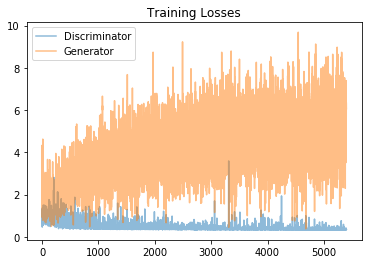

In [34]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [35]:
# Load samples from generator, taken while training
with open('train_samples64.pkl', 'rb') as f:
    samples = pkl.load(f)

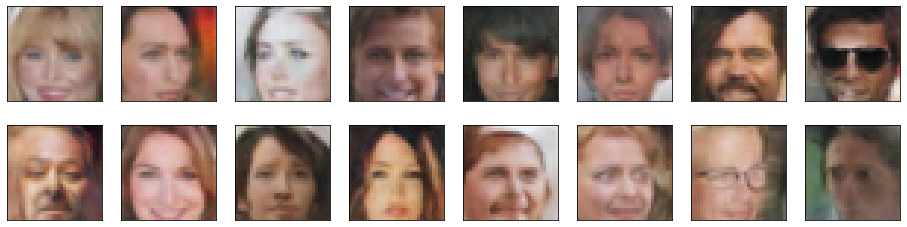

In [36]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

In this model, only white faces were considered, furthermore, few samples had facial objects (like sunglasses) which leads to some strange artifacts in the images. A more complete dataset could lead to more diverse results, but more samples with objects like sunglasses could induce further the strange artifacts in the generated faces. Maybe higher number of epochs could avoid that.

Lager models definitely increases the quality of the output model since it allows it to capture more features.

Other optimization strategies could be used, such as the decaying gradient used in the CycleGAN. There are other optimization strategies which could be explored.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.